# References

This notebook was copied and adapted from Dr. Alvarado's M06_01_SimilarityMeasures notebook.

# Metadata

```
Course:   DS 5001 
Module:   06 Lab
Topic:    Similarity and Distance Measures
Author:   R.C. Alvarado
Adapted by: Nick Keeley
```

# Set Up

In [430]:
data_home = "../data"
data_prefix = 'austen-melville'

In [431]:
OHCO_src = ['book_id', 'chap_id']
OHCO = ['book_id']

In [432]:
import pandas as pd
import numpy as np
import re 
import seaborn as sns; sns.set()

In [433]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist

# Bring in Functions

In [455]:
## Inputs: TOKENS (CORPUS) dataframe; a choice of bag (OHCO) level

def create_BOW(tokens, level):
    
    ## Inputs
    
    bag = level
    
    ## Create BOW table from tokens table
    
    bow = tokens.groupby(bag+['term_str']).term_str.count().to_frame('n') 
    
    ## Return values
    
    return pd.DataFrame(bow)

## Inputs: BOW table, measure

def create_TFIDF(bow, tf_method):
    
    ## Generate DTCM
    
    DTCM = bow.n.unstack()
    
    ## Generate TF
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(DTCM.T + 1)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'bool':
        TF = DTCM.T.astype('bool') #.astype('int')
    TF = TF.T
    
    ## Generate IDF
    
    N=DTCM.shape[0] # The number of chosen bags
    DF=DTCM.count() # Vector containing the number of bags containing any term in vocabulary
    IDF = np.log10(N / DF)
    
    ## Compute TFIDF
    
    TFIDF=TF*IDF
    TFIDF=TFIDF.fillna(0)
    
    ## *NEW* Compute DFIDF
    
    DFIDF=DF*IDF
    DFIDF=pd.DataFrame(DFIDF)
    
    return TFIDF, DFIDF

# Prepare Data

## Acquire Data

We use the results of our previous wor in which TFIDF was computed from a corpus. 

In [435]:
#BOW = pd.read_csv(f"{data_home}/output/{data_prefix}-BOW.csv").set_index(OHCO_src+['term_str'])
#VOCAB = pd.read_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB.csv').set_index('book_id')
CORPUS = pd.read_csv(f"{data_home}/output/{data_prefix}-CORPUS.csv").set_index(OHCO_src+['term_str'])

## Truncate `LIB` titles

In [436]:
LIB.title = LIB.title.apply(lambda x: x[:20])

In [438]:
LIB.head()

source_file_path        author  \
book_id                                                                    
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   

                        title                   chap_regex  book_len  n_chaps  
book_id                                                                        
105                PERSUASION              ^Chapter\s+\d+$     83624       24  
121          NORTHANGER ABBEY              ^CHAPTER\s+\d+$     77601       31  
141            MANSFIELD PARK        ^CHAPTER\s+[IVXLCM]+$    160378       48  
158                      EMMA  ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926       55  
161      SENSE AND SENSIBILIT              ^CHAPTER\s+\d+$    119873       50

In [428]:
## Step 1: Add feature to show year and book title

In [446]:
LIB["year"]=0
LIB.year[LIB.title=="EMMA"]="1815"
LIB.year[LIB.title=="LADY SUSAN"]="1794"
LIB.year[LIB.title=="LOVE AND FREINDSHIP "]="1790"
LIB.year[LIB.title=="MANSFIELD PARK"]="1814"
LIB.year[LIB.title=="NORTHANGER ABBEY"]="1803"
LIB.year[LIB.title=="PERSUASION"]="1818"
LIB.year[LIB.title=="PRIDE AND PREJUDICE"]="1813"
LIB.year[LIB.title=="SENSE AND SENSIBILIT"]="1811"
LIB

<ipython-input-446-6d84236dfa86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIB.year[LIB.title=="EMMA"]="1815"
<ipython-input-446-6d84236dfa86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIB.year[LIB.title=="LADY SUSAN"]="1794"
<ipython-input-446-6d84236dfa86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIB.year[LIB.title=="LOVE AND FREINDSHIP "]="1790"
<ipython-input-446-6d84236dfa86>:5: SettingWithCopyWarning: 
A val

source_file_path            author  \
book_id                                                                        
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
946      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1212     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1342     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1900     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
2701     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
4045     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
8118     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
10712    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13720    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13721    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
15422    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
21816    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
34970    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   

                        title                       chap_regex  book_len  \
book_id                                                                    
105                PERSUASION                  ^Chapter\s+\d+$     83624   
121          NORTHANGER ABBEY                  ^CHAPTER\s+\d+$     77601   
141            MANSFIELD PARK            ^CHAPTER\s+[IVXLCM]+$    160378   
158                      EMMA      ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926   
161      SENSE AND SENSIBILIT                  ^CHAPTER\s+\d+$    119873   
946                LADY SUSAN                ^\s*[IVXLCM]+\s*$     23116   
1212     LOVE AND FREINDSHIP              ^\s*LETTER .* to .*$     33265   
1342      PRIDE AND PREJUDICE                  ^Chapter\s+\d+$    122126   
1900     TYPEE A ROMANCE OF T                        ^CHAPTER     108021   
2701     MOBY DICK OR THE WHA  ^(?:ETYMOLOGY|EXTRACTS|CHAPTER)    215504   
4045     OMOO ADVENTURES IN T    ^\s*CHAPTER\s+[IVXLCM]+\.\s*$    102352   
8118     REDBURN HIS FIRST VO              ^\s*[IVXLCM]+\. .*$    119243   
10712    WHITE JACKET OR THE        ^CHAPTER\s+[IVXLCM]+\.\s*$    143310   
13720    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$     96878   
13721    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$    102092   
15422    ISRAEL POTTER HIS FI        ^\s*CHAPTER\s+[IVXLCM]+\.     65516   
21816    THE CONFIDENCE MAN H         ^CHAPTER\s+[IVXLCM]+\.?$     95315   
34970    PIERRE OR THE AMBIGU              ^\s*[IVXLCM]+\.\s*$    155056   

         n_chaps  year  
book_id                 
105           24  1818  
121           31  1803  
141           48  1814  
158           55  1815  
161           50  1811  
946           41  1794  
1212          24  1790  
1342          61  1813  
1900          34     0  
2701         138     0  
4045          82     0  
8118          78     0  
10712         92     0  
13720        104     0  
13721         91     0  
15422         27     0  
21816         90     0  
34970        114     0

In [447]:
LIB['label'] = LIB.apply(lambda x: f"{x.title}-{x.year}", 1) #DOC.author + ': ' + DOC['title']
LIB

source_file_path            author  \
book_id                                                                        
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
946      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1212     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1342     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1900     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
2701     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
4045     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
8118     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
10712    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13720    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13721    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
15422    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
21816    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
34970    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   

                        title                       chap_regex  book_len  \
book_id                                                                    
105                PERSUASION                  ^Chapter\s+\d+$     83624   
121          NORTHANGER ABBEY                  ^CHAPTER\s+\d+$     77601   
141            MANSFIELD PARK            ^CHAPTER\s+[IVXLCM]+$    160378   
158                      EMMA      ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926   
161      SENSE AND SENSIBILIT                  ^CHAPTER\s+\d+$    119873   
946                LADY SUSAN                ^\s*[IVXLCM]+\s*$     23116   
1212     LOVE AND FREINDSHIP              ^\s*LETTER .* to .*$     33265   
1342      PRIDE AND PREJUDICE                  ^Chapter\s+\d+$    122126   
1900     TYPEE A ROMANCE OF T                        ^CHAPTER     108021   
2701     MOBY DICK OR THE WHA  ^(?:ETYMOLOGY|EXTRACTS|CHAPTER)    215504   
4045     OMOO ADVENTURES IN T    ^\s*CHAPTER\s+[IVXLCM]+\.\s*$    102352   
8118     REDBURN HIS FIRST VO              ^\s*[IVXLCM]+\. .*$    119243   
10712    WHITE JACKET OR THE        ^CHAPTER\s+[IVXLCM]+\.\s*$    143310   
13720    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$     96878   
13721    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$    102092   
15422    ISRAEL POTTER HIS FI        ^\s*CHAPTER\s+[IVXLCM]+\.     65516   
21816    THE CONFIDENCE MAN H         ^CHAPTER\s+[IVXLCM]+\.?$     95315   
34970    PIERRE OR THE AMBIGU              ^\s*[IVXLCM]+\.\s*$    155056   

         n_chaps  year                      label  
book_id                                            
105           24  1818            PERSUASION-1818  
121           31  1803      NORTHANGER ABBEY-1803  
141           48  1814        MANSFIELD PARK-1814  
158           55  1815                  EMMA-1815  
161           50  1811  SENSE AND SENSIBILIT-1811  
946           41  1794            LADY SUSAN-1794  
1212          24  1790  LOVE AND FREINDSHIP -1790  
1342          61  1813   PRIDE AND PREJUDICE-1813  
1900          34     0     TYPEE A ROMANCE OF T-0  
2701         138     0     MOBY DICK OR THE WHA-0  
4045          82     0     OMOO ADVENTURES IN T-0  
8118          78     0     REDBURN HIS FIRST VO-0  
10712         92     0     WHITE JACKET OR THE -0  
13720        104     0     MARDI AND A VOYAGE T-0  
13721         91     0     MARDI AND A VOYAGE T-0  
15422         27     0     ISRAEL PO

In [452]:
## Step 2: Generate BOW and TFIDF

OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
CORPUS.head()
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]
CORPUS=CORPUS.reset_index()

## Find all the Austen books

austen_book_id=list(LIB.index[LIB["author"]=="AUSTEN, JANE"])
austen_book_id

## Filter CORPUS for Austen book_id

CORPUS_A=CORPUS[CORPUS.book_id.isin(austen_book_id)]

## Create the BOW for selected Austen novels

BOW=create_BOW(CORPUS_A,CHAPS)
BOW

## Create TFIDF and DFIDF

TFIDF, DFIDF = create_TFIDF(BOW, "max")
DFIDF # DFIDF is the number of bags, in this case chaps, containing terms


ValueError: cannot insert level_0, already exists

In [454]:
DFIDF

0
term_str            
0           2.523746
1           4.445433
10          6.139876
10000       2.523746
10th        4.445433
...              ...
zealous    10.473571
zealously   4.445433
zephyr      2.523746
zigzags     2.523746
ł20000      2.523746

[14745 rows x 1 columns]

In [372]:
#BOW.loc[(105,3)]

In [456]:
## Find the max_pos for each term in vocabulary

VOCAB=pd.DataFrame(DFIDF)
VOCAB.rename(columns={0:"dfidf"}, inplace=True)
VOCAB_A=CORPUS_A.groupby("term_str").agg({"pos":"max"}).sort_values(by="term_str")
DFIDF=DFIDF.sort_values(by="term_str")
DFIDF["max_pos"]=VOCAB_A.pos
DFIDF
# temp=CORPUS_A[["term_str","pos"]]
# temp=temp.sort_values(by="term_str")
# temp.head(20)
# DFIDF.head(20)

dfidf max_pos
term_str                    
0           2.523746      CD
1           4.445433      CD
10          6.139876      CD
10000       2.523746      CD
10th        4.445433     NNS
...              ...     ...
zealous    10.473571      JJ
zealously   4.445433      RB
zephyr      2.523746     NNP
zigzags     2.523746      NN
ł20000      2.523746      NN

[14745 rows x 2 columns]

In [459]:
## Create cutoff criteria

DFIDF=DFIDF.sort_values(by="dfidf", ascending=False)
keep=["NN", "NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS", "RB", "RBR", "RBS"]
DFIDF_keep=DFIDF[DFIDF.max_pos.isin(keep)].sort_values(by="dfidf",ascending=False)
DFIDF_keep=DFIDF_keep.iloc[0:1000]
keep_words=list(DFIDF_keep.index)

In [460]:
## Use cutoff to filter TFIDF

TFIDF_keep=TFIDF[keep_words]
TFIDF_mean=TFIDF_keep.groupby("book_id").mean()
TFIDF_mean
#TFIDF_mean=TFIDF_mean.fillna(0) # imputed 0 for NA values
TFIDF_mean

term_str     among   respect  greatest      stay   forward  thinking  \
book_id                                                                
105       0.005498  0.001848  0.000973  0.003186  0.002788  0.003414   
121       0.002158  0.001237  0.002205  0.002652  0.002031  0.002481   
141       0.002933  0.002724  0.003117  0.002833  0.002860  0.003257   
158       0.004012  0.003432  0.002155  0.003429  0.002674  0.004394   
161       0.001898  0.001956  0.002856  0.002447  0.001949  0.001610   
946       0.000000  0.003057  0.004687  0.001697  0.003067  0.000378   
1212      0.000281  0.000941  0.003026  0.000266  0.000452  0.001059   
1342      0.002374  0.002865  0.001672  0.003707  0.002034  0.002201   

term_str  marriage    assure   fortune      four  ...     books  improvement  \
book_id                                           ...                          
105       0.003452  0.003072  0.004091  0.002812  ...  0.002559     0.002271   
121       0.001704  0.002695  0.003026  0.003754  ...  0.003350     0.001764   
141       0.002231  0.001297  0.002091  0.002763  ...  0.002044     0.002623   
158       0.002852  0.004396  0.003111  0.002159  ...  0.001026     0.001314   
161       0.004000  0.002964  0.003893  0.003470  ...  0.002637     0.001815   
946       0.006607  0.001660  0.001618  0.000288  ...  0.002713     0.000333   
1212      0.004938  0.003353  0.003435  0.002330  ...  0.000427     0.000206   
1342      0.006161  0.004129  0.004313  0.003662  ...  0.003074     0.001894   

term_str   harriet  perceive     james      grew  perceived     lines  \
book_id                                                                 
105       0.000000  0.000967  0.001454  0.001183   0.000714  0.001509   
121       0.000431  0.001246  0.016498  0.002786   0.001457  0.000905   
141       0.000000  0.001188  0.000143  0.002746   0.000722  0.002064   
158       0.060902  0.000945  0.002707  0.001574   0.001312  0.002332   
161       0.000000  0.002717  0.000157  0.000974   0.002808  0.000520   
946       0.000000  0.001179  0.026818  0.000000   0.000333  0.005833   
1212      0.000000  0.000998  0.000838  0.000241   0.001176  0.000206   
1342      0.000306  0.000965  0.000000  0.001032   0.001841  0.001760   

term_str  obliging     place  
book_id                       
105       0.001465  0.004883  
121       0.000643  0.003550  
141       0.001578  0.002679  
158       0.004704  0.002965  
161       0.000351  0.003508  
946       0.001000  0.001853  
1212      0.001328  0.001368  
1342      0.000840  0.002652  

[8 rows x 1000 columns]

In [461]:
## Normalize vectors. NOTE: had to impute 0 for NAs

L0 = TFIDF_mean.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF_mean.apply(lambda x: x / x.sum(), 1) # Manhattan
L2 = TFIDF_mean.apply(lambda x: x / norm(x), 1) # Euclidean

In [465]:
L2

term_str     among   respect  greatest      stay   forward  thinking  \
book_id                                                                
105       0.063619  0.021384  0.011261  0.036863  0.032259  0.039497   
121       0.017119  0.009815  0.017493  0.021035  0.016112  0.019678   
141       0.022588  0.020976  0.024005  0.021818  0.022021  0.025083   
158       0.025198  0.021555  0.013530  0.021536  0.016790  0.027593   
161       0.010636  0.010958  0.016003  0.013709  0.010919  0.009019   
946       0.000000  0.033368  0.051158  0.018525  0.033476  0.004125   
1212      0.003146  0.010525  0.033839  0.002976  0.005054  0.011839   
1342      0.019678  0.023748  0.013855  0.030722  0.016859  0.018244   

term_str  marriage    assure   fortune      four  ...     books  improvement  \
book_id                                           ...                          
105       0.039944  0.035546  0.047332  0.032531  ...  0.029614     0.026274   
121       0.013513  0.021379  0.024005  0.029774  ...  0.026574     0.013991   
141       0.017182  0.009985  0.016101  0.021274  ...  0.015741     0.020198   
158       0.017911  0.027608  0.019535  0.013559  ...  0.006442     0.008252   
161       0.022413  0.016609  0.021815  0.019443  ...  0.014778     0.010172   
946       0.072119  0.018115  0.017660  0.003147  ...  0.029607     0.003638   
1212      0.055221  0.037495  0.038416  0.026060  ...  0.004776     0.002306   
1342      0.051063  0.034221  0.035751  0.030351  ...  0.025481     0.015697   

term_str   harriet  perceive     james      grew  perceived     lines  \
book_id                                                                 
105       0.000000  0.011183  0.016824  0.013689   0.008257  0.017460   
121       0.003415  0.009882  0.130858  0.022099   0.011556  0.007179   
141       0.000000  0.009147  0.001101  0.021142   0.005557  0.015893   
158       0.382453  0.005932  0.016997  0.009887   0.008237  0.014645   
161       0.000000  0.015223  0.000877  0.005456   0.015736  0.002912   
946       0.000000  0.012864  0.292711  0.000000   0.003638  0.063669   
1212      0.000000  0.011160  0.009367  0.002691   0.013149  0.002306   
1342      0.002538  0.008000  0.000000  0.008551   0.015261  0.014591   

term_str  obliging     place  
book_id                       
105       0.016949  0.056499  
121       0.005097  0.028157  
141       0.012148  0.020631  
158       0.029543  0.018618  
161       0.001967  0.019655  
946       0.010915  0.020229  
1212      0.014853  0.015302  
1342      0.006962  0.021984  

[8 rows x 1000 columns]

In [466]:
round(L1.sum(1).sum()) == len(TFIDF_mean)

True

In [467]:
round(((L2.T)**2).sum().sum()) == len(TFIDF_mean)

True

In [468]:
## Compute Pairs

PAIRS = 1 - TFIDF_mean.T.corr().stack().to_frame('corr–raw') # 1 - corr() is considered a distance measure
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [469]:
PAIRS

corr–raw
doc_a doc_b          
121   105    0.923407
141   105    0.925528
      121    1.002755
158   105    1.029676
      121    1.033654
      141    1.042686
161   105    1.050696
      121    1.028979
      141    1.022902
      158    1.044810
946   105    0.986236
      121    0.811412
      141    1.017651
      158    1.045644
      161    0.981342
1212  105    0.903686
      121    0.963704
      141    0.995904
      158    1.010405
      161    0.908146
      946    0.789575
1342  105    0.693539
      121    0.865350
      141    1.022685
      158    0.978698
      161    1.025498
      946    0.971253
      1212   0.920262

In [470]:
## Compute distance metrics

combos  = [
    (TFIDF_mean, 'cityblock', 'cityblock–raw'),
    (TFIDF_mean, 'cosine', 'cosine–raw'),
    (L2, 'euclidean', 'euclidean–l2'),    
    (L0, 'jaccard', 'jaccard–l0'),
    (L1, 'jensenshannon', 'js–l1')
]

In [471]:
for X, metric, label in combos:
    PAIRS[label] = pdist(X, metric)

In [472]:
PAIRS

corr–raw  cityblock–raw  cosine–raw  euclidean–l2  jaccard–l0  \
doc_a doc_b                                                                  
121   105    0.923407       1.220716    0.478251      0.978009    0.014070   
141   105    0.925528       1.076287    0.488912      0.988850    0.008048   
      121    1.002755       1.278389    0.569564      1.067299    0.016048   
158   105    1.029676       1.429592    0.633740      1.125824    0.008040   
      121    1.033654       1.732808    0.432941      0.930528    0.122736   
      141    1.042686       1.757074    0.410891      0.906522    0.104628   
161   105    1.050696       1.227896    0.318605      0.798254    0.010050   
      121    1.028979       1.273650    0.659302      1.148304    0.012072   
      141    1.022902       1.488391    0.703302      1.186003    0.016080   
      158    1.044810       1.466243    0.739129      1.215836    0.012060   
946   105    0.986236       1.739919    0.485386      0.985278    0.117290   
      121    0.811412       1.822914    0.584130      1.080861    0.110553   
      141    1.017651       1.312978    0.522581      1.022332    0.010070   
      158    1.045644       1.305423    0.716354      1.196958    0.014056   
      161    0.981342       1.485531    0.740816      1.217223    0.006036   
1212  105    0.903686       1.720413    0.615449      1.109459    0.120846   
      121    0.963704       1.833733    0.611614      1.105996    0.108434   
      141    0.995904       1.274681    0.624987      1.118023    0.010050   
      158    1.010405       1.646660    0.776045      1.245829    0.018018   
      161    0.908146       1.949439    0.659513      1.148488    0.124748   
      946    0.789575       2.040488    0.646518      1.137117    0.108543   
1342  105    0.693539       1.410994    0.624066      1.117198    0.014056   
      121    0.865350       1.875948    0.663389      1.151858    0.120724   
      141    1.022685       1.910286    0.622686      1.115962    0.106426   
      158    0.978698       1.355231    0.697230      1.180873    0.010040   
      161    1.025498       1.757396    0.430749      0.928169    0.186475   
      946    0.971253       1.705907    0.526574      1.026230    0.117053   
      1212   0.920262       1.788996    0.508714      1.008676    0.108434   

                js–l1  
doc_a doc_b            
121   105    0.272887  
141   105    0.247184  
      121    0.278435  
158   105    0.300121  
      121    0.381531  
      141    0.386424  
161   105    0.242002  
      121    0.288267  
      141    0.312159  
      158    0.311781  
946   105    0.373241  
      121    0.396520  
      141    0.272986  
      158    0.297907  
      161    0.313585  
1212  105    0.384148  
      121    0.398417  
      141    0.275470  
      158    0.331728  
      161    0.395665  
      946    0.407420  
1342  105    0.292064  
      121    0.389875  
      141    0.388561  
      158    0.293668  
      161    0.424894  
      946    0.364984  
      1212   0.371278

In [473]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [474]:
def hca(sims, title="My Dendrogram", linkage_method='weighted', color_thresh=None, figsize=(7, 7)):

    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB_A.label.values
    if not color_thresh:
        color_thresh = pd.DataFrame(tree)[2].median()
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(title, fontsize=20)

In [475]:
LIB_A=LIB[LIB.author=="AUSTEN, JANE"]
LIB_A.label.values
LIB_A

source_file_path        author  \
book_id                                                                    
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
946      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
1212     ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
1342     ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   

                        title                   chap_regex  book_len  n_chaps  \
book_id                                                                         
105                PERSUASION              ^Chapter\s+\d+$     83624       24   
121          NORTHANGER ABBEY              ^CHAPTER\s+\d+$     77601       31   
141            MANSFIELD PARK        ^CHAPTER\s+[IVXLCM]+$    160378       48   
158                      EMMA  ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926       55   
161      SENSE AND SENSIBILIT              ^CHAPTER\s+\d+$    119873       50   
946                LADY SUSAN            ^\s*[IVXLCM]+\s*$     23116       41   
1212     LOVE AND FREINDSHIP          ^\s*LETTER .* to .*$     33265       24   
1342      PRIDE AND PREJUDICE              ^Chapter\s+\d+$    122126       61   

         year                      label  
book_id                                   
105      1818            PERSUASION-1818  
121      1803      NORTHANGER ABBEY-1803  
141      1814        MANSFIELD PARK-1814  
158      1815                  EMMA-1815  
161      1811  SENSE AND SENSIBILIT-1811  
946      1794            LADY SUSAN-1794  
1212     1790  LOVE AND FREINDSHIP -1790  
1342     1813   PRIDE AND PREJUDICE-1813

<Figure size 432x288 with 0 Axes>

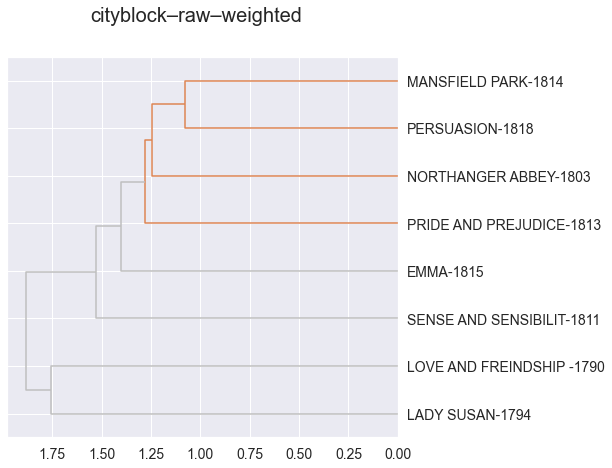

In [476]:
# sch.dendrogram?

linkages=["weighted","ward","ward","weighted","weighted"]
m=combos[0][-1]
l=linkages[0]
title = f"{m}–{l}"
hca(PAIRS.iloc[:,1], title, linkage_method=l)

<Figure size 432x288 with 0 Axes>

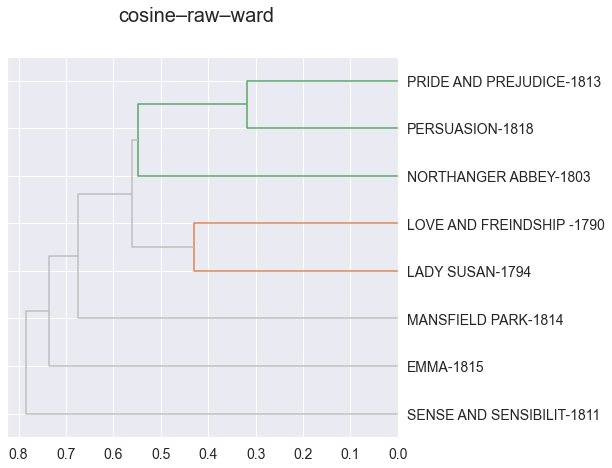

In [477]:
linkages=["weighted","ward","ward","weighted","weighted"]
m=combos[1][-1]
l=linkages[1]
title = f"{m}–{l}"
hca(PAIRS.iloc[:,2], title, linkage_method=l)

<Figure size 432x288 with 0 Axes>

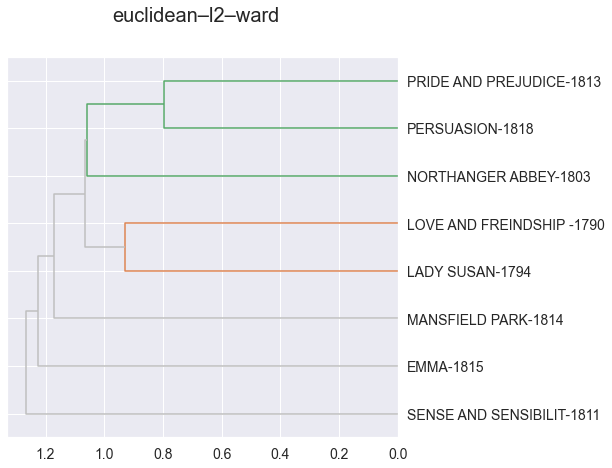

In [478]:
linkages=["weighted","ward","ward","weighted","weighted"]
m=combos[2][-1]
l=linkages[2]
title = f"{m}–{l}"
hca(PAIRS.iloc[:,3], title, linkage_method=l)

<Figure size 432x288 with 0 Axes>

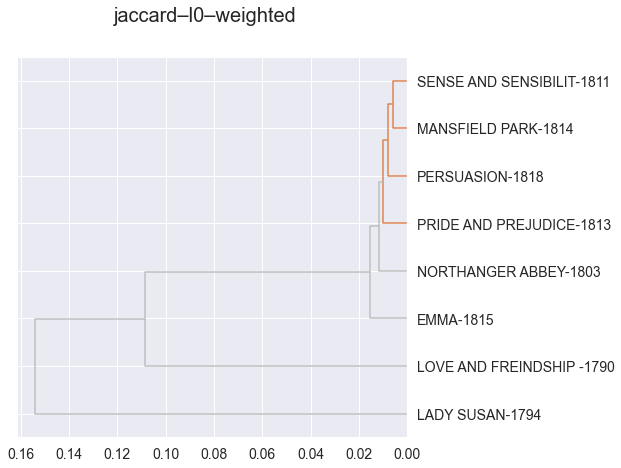

In [479]:
linkages=["weighted","ward","ward","weighted","weighted"]
m=combos[3][-1]
l=linkages[3]
title = f"{m}–{l}"
hca(PAIRS.iloc[:,4], title, linkage_method=l)

<Figure size 432x288 with 0 Axes>

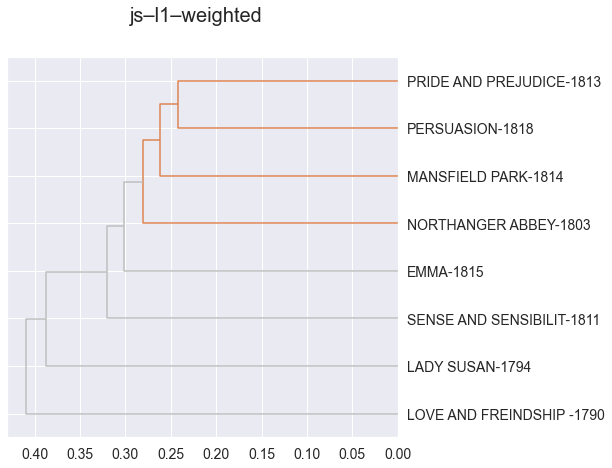

In [480]:
linkages=["weighted","ward","ward","weighted","weighted"]
m=combos[4][-1]
l=linkages[4]
title = f"{m}–{l}"
hca(PAIRS.iloc[:,5], title, linkage_method=l)

In [481]:
cut=["NN","NNS"]
DFIDF[DFIDF.max_pos.isin(cut)].sort_values(by="dfidf",ascending=False).head(10).index #.sort_values(by="dfidf", ascending=False).head(10)

Index(['greatest', 'former', 'voice', 'year', 'hours', 'common', 'thoughts',
       'particular', 'second', 'moments'],
      dtype='object', name='term_str')

In [486]:
TFIDF_mean.agg("mean",axis=1).sort_values(ascending=False)

book_id
158     0.002721
161     0.002686
1342    0.002561
141     0.002378
121     0.002358
105     0.002249
946     0.001976
1212    0.001884
dtype: float64

In [514]:
## Code for quiz 6

D1 = [0, 5, 9, 3, 0, 5, 9, 0, 0, 0, 9, 7, 0]
D2 = [5, 5, 0, 3, 0, 5, 2, 0, 1, 0, 9, 5, 0]
D3 = pd.DataFrame(D1)
D3["D2"]=D2
D3=D3.rename(columns={0:"D1"})
D3["r"]=(D3.D2-D3.D1)**2
np.sqrt(D3.r.sum())

12.649110640673518

## -- End of my work --


<ipython-input-386-1087c7276b27>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

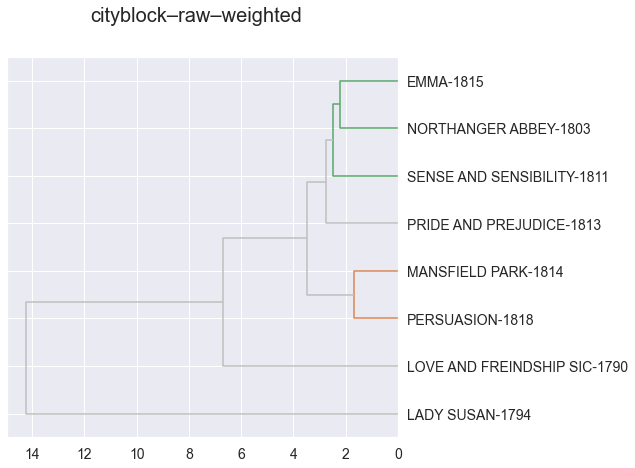

<Figure size 432x288 with 0 Axes>

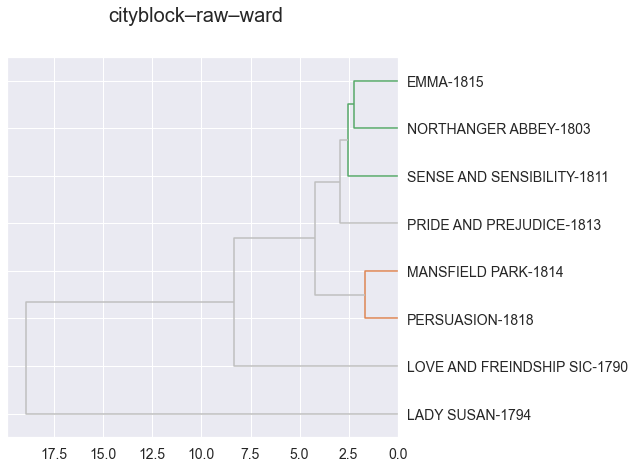

<Figure size 432x288 with 0 Axes>

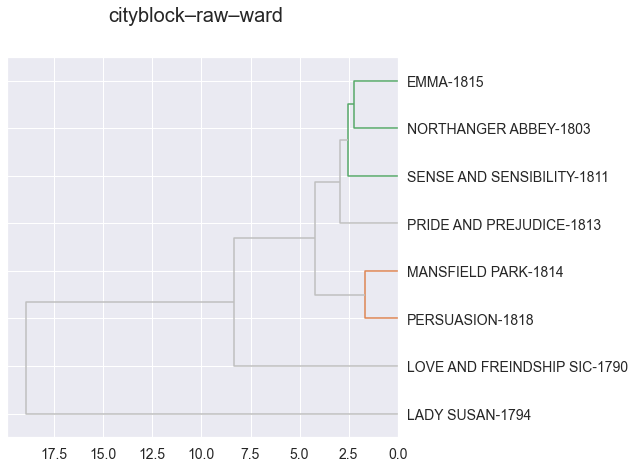

<Figure size 432x288 with 0 Axes>

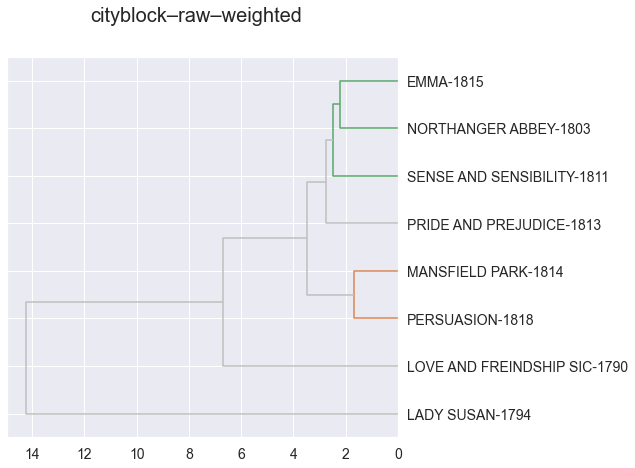

<Figure size 432x288 with 0 Axes>

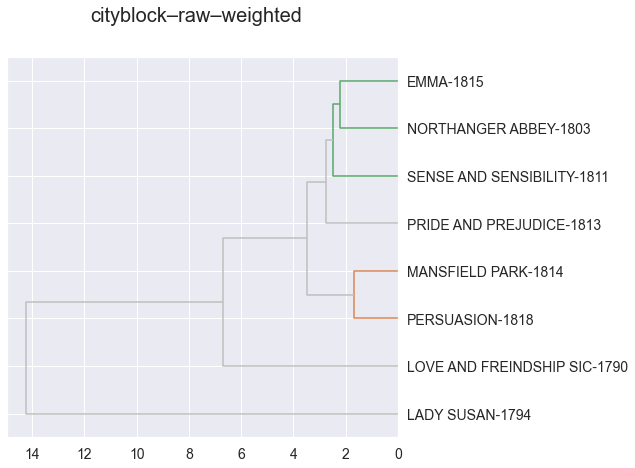

<Figure size 432x288 with 0 Axes>

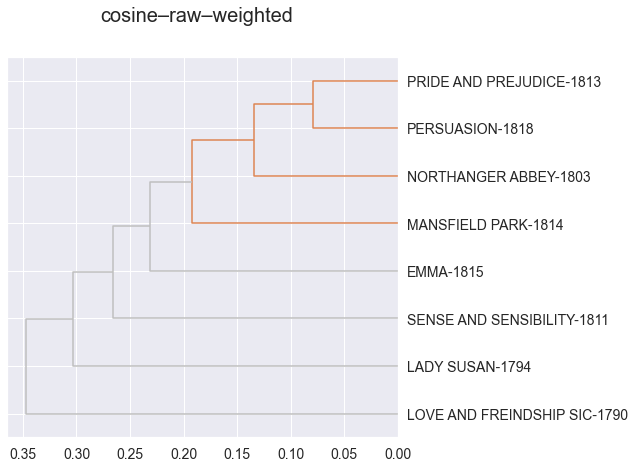

<Figure size 432x288 with 0 Axes>

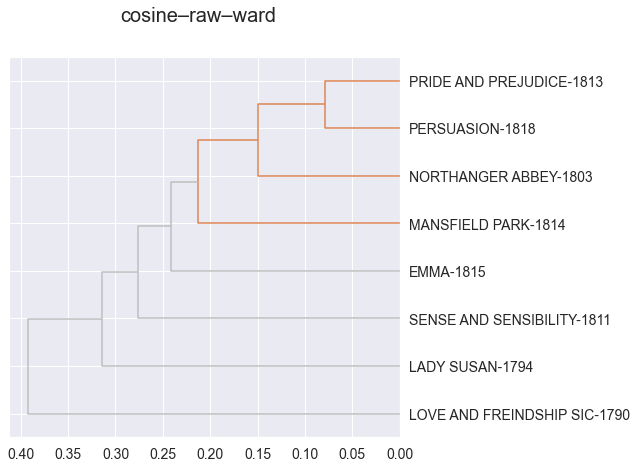

<Figure size 432x288 with 0 Axes>

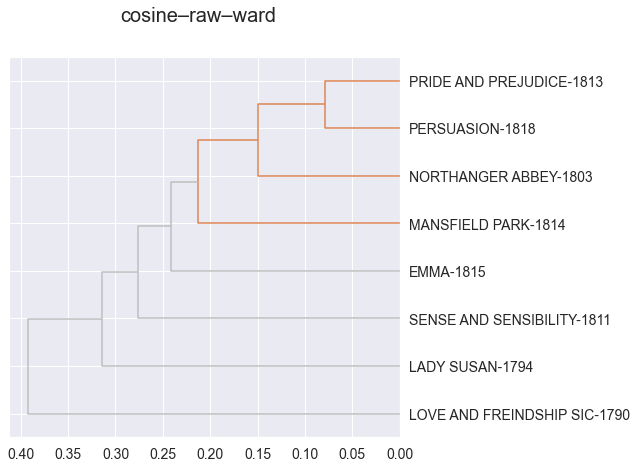

<Figure size 432x288 with 0 Axes>

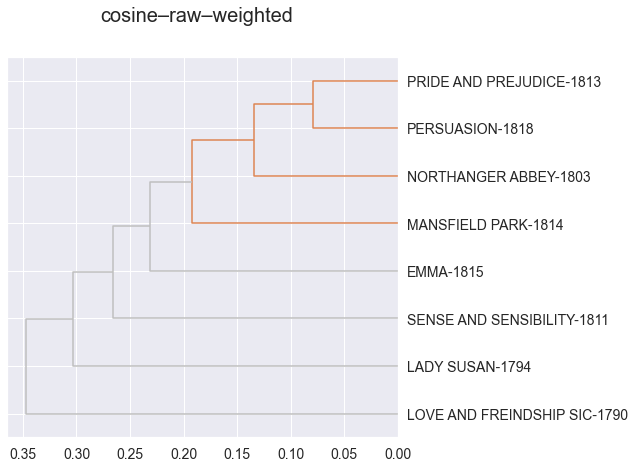

<Figure size 432x288 with 0 Axes>

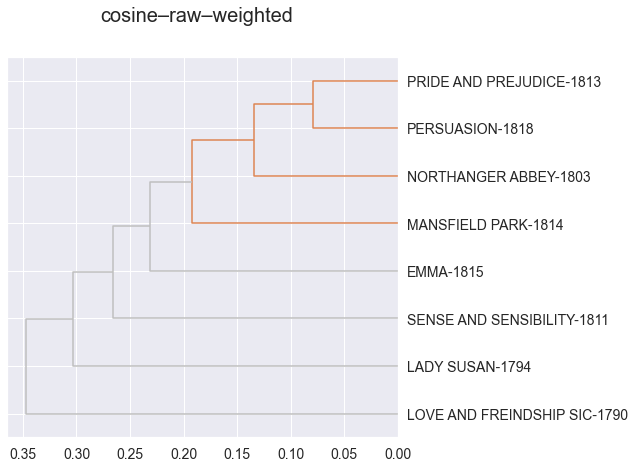

<Figure size 432x288 with 0 Axes>

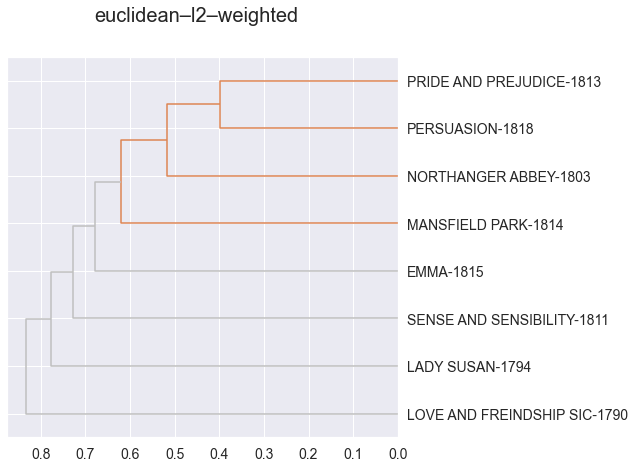

<Figure size 432x288 with 0 Axes>

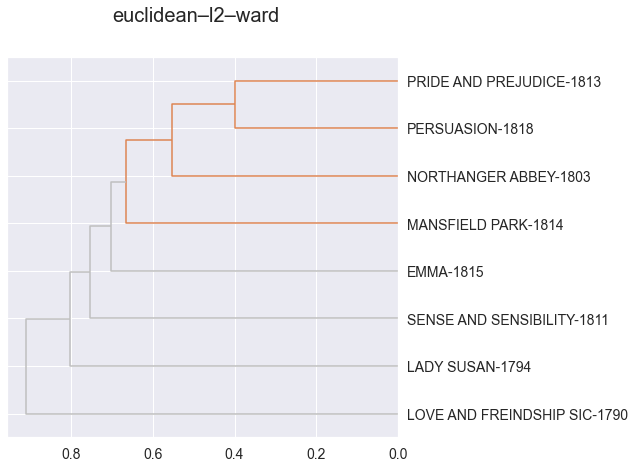

<Figure size 432x288 with 0 Axes>

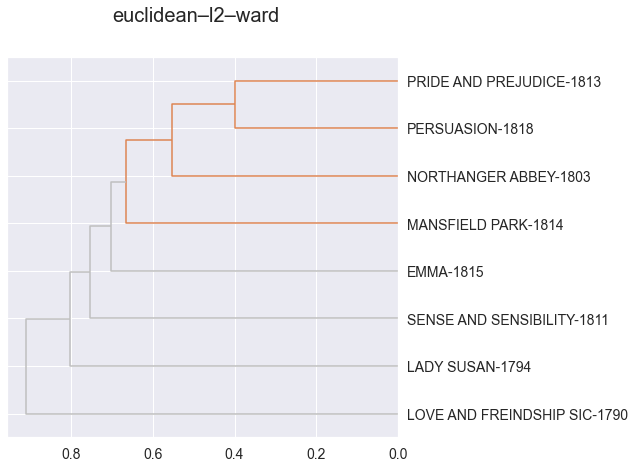

<Figure size 432x288 with 0 Axes>

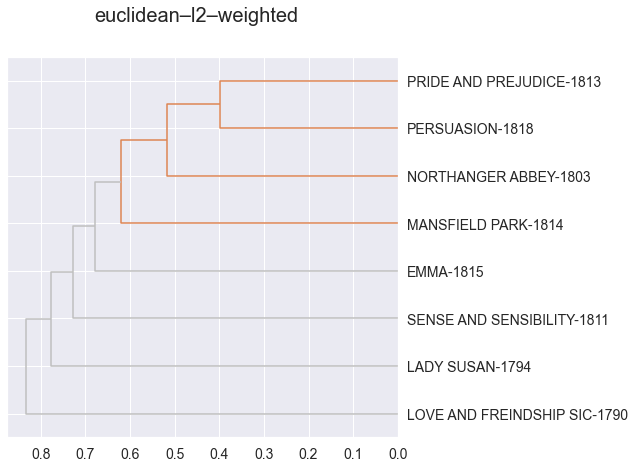

<Figure size 432x288 with 0 Axes>

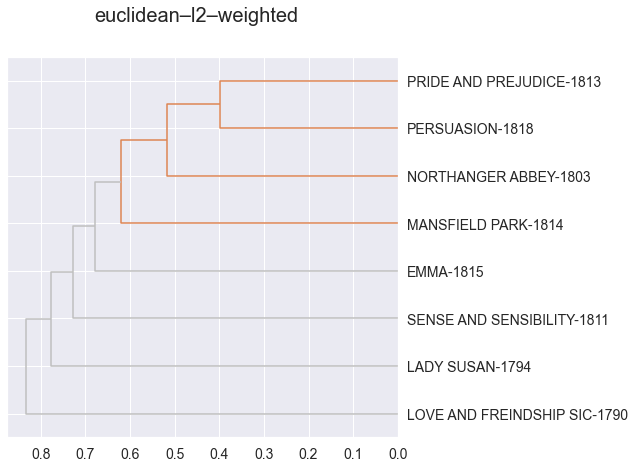

<Figure size 432x288 with 0 Axes>

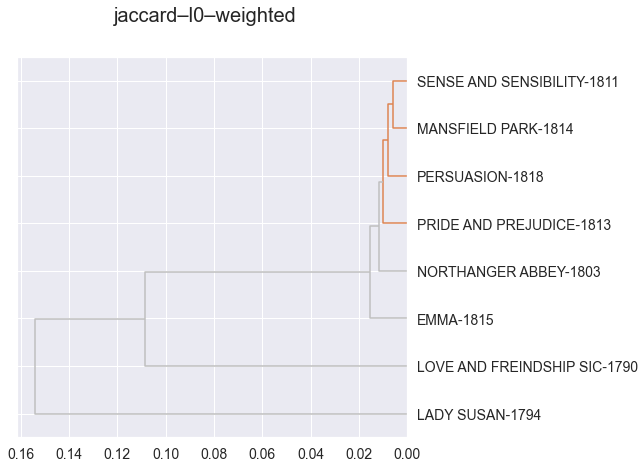

<Figure size 432x288 with 0 Axes>

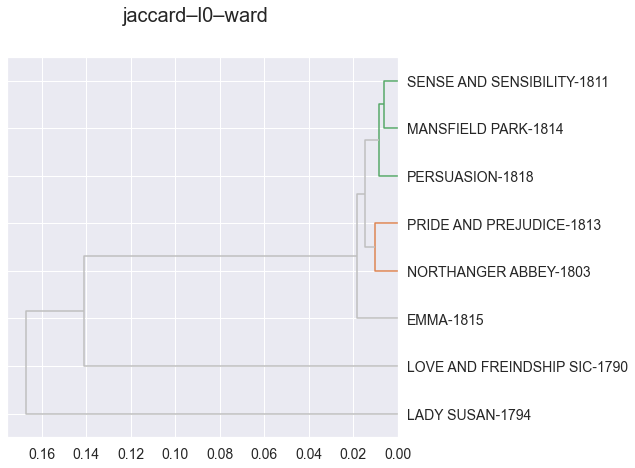

<Figure size 432x288 with 0 Axes>

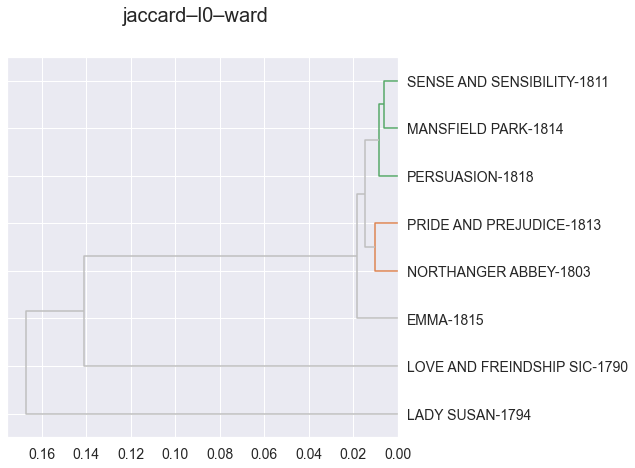

<Figure size 432x288 with 0 Axes>

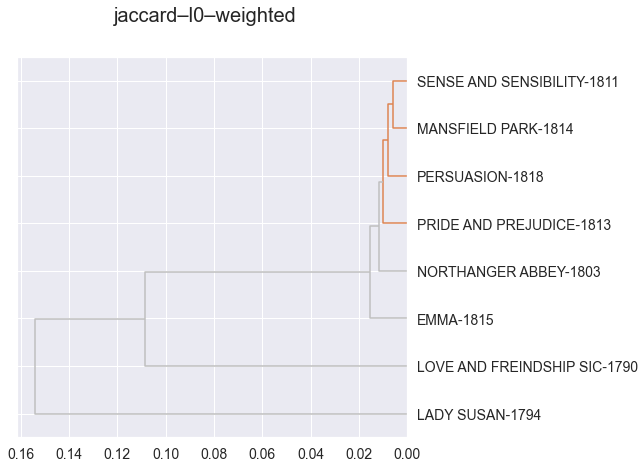

<Figure size 432x288 with 0 Axes>

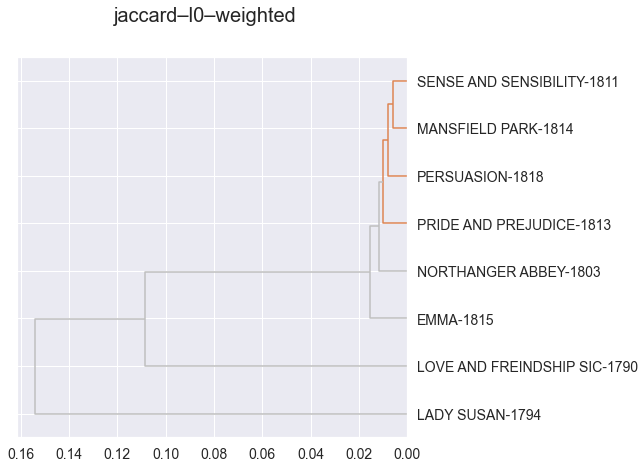

<Figure size 432x288 with 0 Axes>

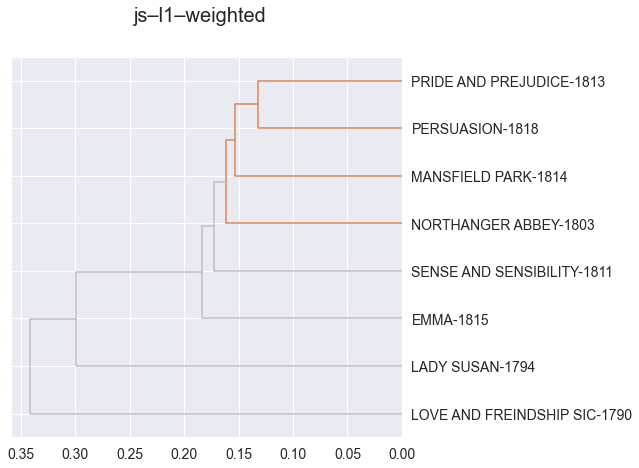

<Figure size 432x288 with 0 Axes>

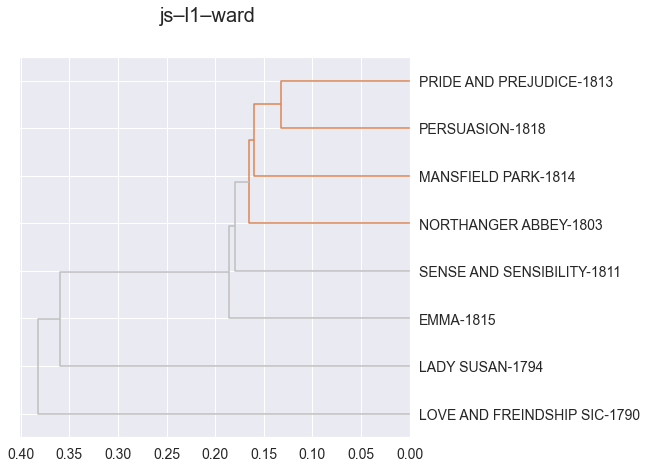

<Figure size 432x288 with 0 Axes>

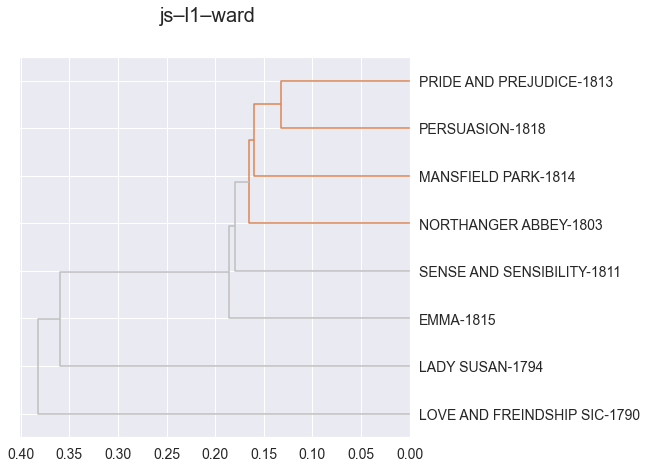

<Figure size 432x288 with 0 Axes>

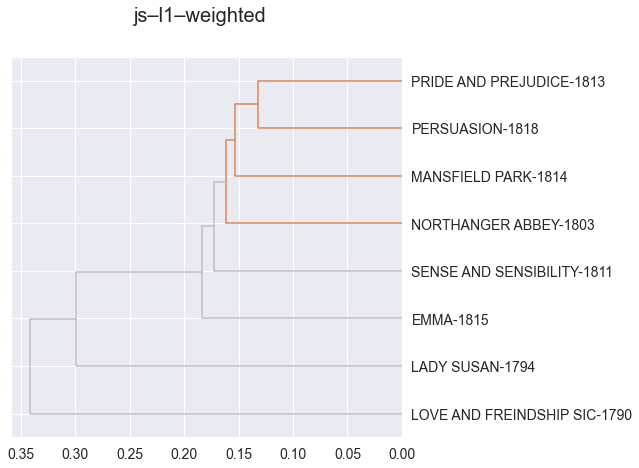

<Figure size 432x288 with 0 Axes>

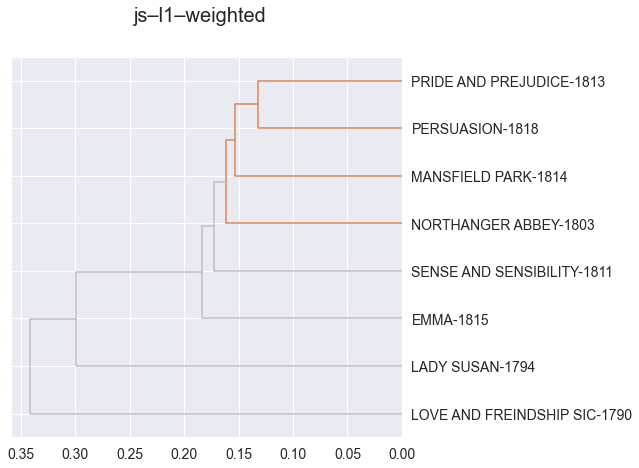

In [393]:
for combo in combos:
    m = combo[-1]
    for l in linkages:
        title = f"{m}–{l}"
        hca(PAIRS[m], title, linkage_method=l)

## Unstack `BOW` into `TFIDIF` matrix

This is a document-term matrix with TFIDF weights.

In [8]:
TFIDF = BOW.tfidf.unstack(fill_value=0)

In [9]:
TFIDF.head()

term_str           0         1   10  100  1000  10000  10440  10800  10th  \
book_id chap_id                                                             
105     1        0.0  0.001548  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        2        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        3        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        4        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        5        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   

term_str         118952  ...  zoroaster  zozo  zuma  zur    à  æneas  æniad  \
book_id chap_id          ...                                                  
105     1           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        2           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        3           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        4           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        5           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   

term_str         æson  æsops  ł20000  
book_id chap_id                       
105     1         0.0    0.0     0.0  
        2         0.0    0.0     0.0  
        3         0.0    0.0     0.0  
        4         0.0    0.0     0.0  
        5         0.0    0.0     0.0  

[5 rows x 39424 columns]

In [95]:
VOCAB

term_rank       n  n_chars             p          i max_pos  \
term_str                                                                      
the                     1  104874        3  5.286718e-02   4.241484      DT   
of                      2   63153        2  3.183555e-02   4.973218      IN   
and                     3   61104        3  3.080264e-02   5.020802      CC   
to                      4   54397        2  2.742163e-02   5.188542      TO   
a                       5   42556        1  2.145256e-02   5.542706      DT   
...                   ...     ...      ...           ...        ...     ...   
glockner            39422       1        8  5.041019e-07  20.919781     NNP   
samsons             39423       1        7  5.041019e-07  20.919781     NNP   
gloating            39424       1        8  5.041019e-07  20.919781      NN   
sanctification      39425       1       14  5.041019e-07  20.919781      NN   
ł20000              39426       1        6  5.041019e-07  20.919781      NN   

                n_pos  stop stem_porter stem_snowball  ... max_pos_group  \
term_str                                               ...                 
the                17     1         the           the  ...            DT   
of                 15     1          of            of  ...            IN   
and                17     1         and           and  ...            CC   
to                 19     1          to            to  ...            TO   
a                  12     1           a             a  ...            DT   
...               ...   ...         ...           ...  ...           ...   
glockner            1     0    glockner      glockner  ...            NN   
samsons             1     0      samson        samson  ...            NN   
gloating            1     0       gloat         gloat  ...            NN   
sanctification      1     0     sanctif       sanctif  ...            NN   
ł20000              1     0      ł20000        ł20000  ...            NN   

               term_rank2  zipf_k  zipf_k2      df       idf  tfidf_mean  \
term_str                                                                   
the                     1  104874   104874  1156.0  0.010394    0.000609   
of                      2  126306   126306  1150.0  0.012654    0.000436   
and                     3  183312   183312  1129.0  0.020658    0.000649   
to                      4  217588   217588  1132.0  0.019505    0.000517   
a                       5  212780   212780  1142.0  0.015686    0.000372   
...                   ...     ...      ...     ...       ...         ...   
glockner              777   39422      777     1.0  3.073352    0.001095   
samsons               777   39423      777     1.0  3.073352    0.001884   
gloating              777   39424      777     1.0  3.073352    0.000843   
sanctification        777   39425      777     1.0  3.073352    0.001396   
ł20000                777   39426      777     1.0  3.073352    0.000678   

                tfidf_max      dfidf    dfidf2  
term_str                                        
the              0.005197  12.015312  0.010148  
of               0.004218  14.551941  0.012290  
and              0.005164  23.322612  0.019698  
to               0.001951  22.079972  0.018649  
a                0.005229  17.912953  0.015129  
...                   ...        ...       ...  
glockner         0.001095   3.073352  0.002596  
samsons          0.001884   3.073352  0.002596  
gloating         0.000843   3.073352  0.002596  
sanctification   0.001396   3.073352  0.002596  
ł20000           0.000678   3.073352  0.002596  

[39426 rows x 21 columns]

## Reduce `VOCAB` 

We use DFIDF to reduce the dimensionality of our `VOCAB` table by an order of magnitude. You may use other reduction measures (such as mean `TFIDF` to what effects this change has on our results.)

In [10]:
sum_method = 'dfidf'
cut_off = VOCAB[sum_method].quantile(.9)

In [11]:
cut_off

51.30964616279745

In [12]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns

In [13]:
SIGS = (VOCAB[sum_method] >= cut_off) & (VOCAB.max_pos.isin(pos_list))

In [14]:
VOCAB_SHORT = VOCAB.loc[SIGS]

In [15]:
len(VOCAB_SHORT)

3728

In [16]:
VOCAB_SHORT

term_rank      n  n_chars         p          i max_pos  n_pos  \
term_str                                                                     
had                 21  13266        3  0.006687   7.224336     VBD     14   
is                  22  13123        2  0.006615   7.239971     VBZ     14   
have                27  10099        4  0.005091   7.617857      VB      8   
were                35   7928        4  0.003997   7.967040     VBD     13   
very                42   6150        4  0.003100   8.333411      RB      9   
...                ...    ...      ...       ...        ...     ...    ...   
appearances       4678     33       11  0.000017  15.875387     NNS      6   
relish            4718     33        6  0.000017  15.875387      NN      4   
elbow             4732     33        5  0.000017  15.875387      NN      5   
avail             4751     33        5  0.000017  15.875387      VB      5   
traced            4783     33        6  0.000017  15.875387     VBN      4   

             stop stem_porter stem_snowball  ... max_pos_group term_rank2  \
term_str                                     ...                            
had             1         had           had  ...            VB         21   
is              1          is            is  ...            VB         22   
have            1        have          have  ...            VB         27   
were            1        were          were  ...            VB         35   
very            1        veri          veri  ...            RB         42   
...           ...         ...           ...  ...           ...        ...   
appearances     0      appear        appear  ...            NN        745   
relish          0      relish        relish  ...            NN        745   
elbow           0       elbow         elbow  ...            NN        745   
avail           0       avail         avail  ...            VB        745   
traced          0       trace         trace  ...            VB        745   

             zipf_k  zipf_k2      df       idf  tfidf_mean  tfidf_max  \
term_str                                                                
had          278586   278586  1017.0  0.066031    0.000424   0.001861   
is           288706   288706  1049.0  0.052576    0.000402   0.004381   
have         272673   272673  1041.0  0.055901    0.000287   0.007986   
were         277480   277480  1015.0  0.066886    0.000292   0.001167   
very         258300   258300   916.0  0.111456    0.000418   0.055728   
...             ...      ...     ...       ...         ...        ...   
appearances  154374    24585    33.0  1.554838    0.000861   0.002492   
relish       155694    24585    33.0  1.554838    0.001000   0.003329   
elbow        156156    24585    33.0  1.554838    0.000868   0.002723   
avail        156783    24585    33.0  1.554838    0.000800   0.002681   
traced       157839    24585    33.0  1.554838    0.000925   0.002476   

                  dfidf    dfidf2  
term_str                           
had           67.153272  0.056717  
is            55.152449  0.046581  
have          58.192913  0.049149  
were          67.888945  0.057339  
very         102.093906  0.086228  
...                 ...       ...  
appearances   51.309646  0.043336  
relish        51.309646  0.043336  
elbow         51.309646  0.043336  
avail         51.309646  0.043336  
traced        51.309646  0.043336  

[3728 rows x 21 columns]

## Apply to `TFIDF`

In [17]:
TFIDF = TFIDF[VOCAB_SHORT.index]

In [18]:
TFIDF

term_str              had        is      have      were      very      been  \
book_id chap_id                                                               
105     1        0.001861  0.000100  0.000256  0.000331  0.000679  0.000885   
        2        0.000937  0.000107  0.000396  0.000203  0.000678  0.000753   
        3        0.000442  0.000482  0.000453  0.000118  0.000864  0.000327   
        4        0.001793  0.000000  0.000372  0.000222  0.000309  0.001235   
        5        0.000656  0.000158  0.000740  0.000483  0.000637  0.000531   
...                   ...       ...       ...       ...       ...       ...   
34970   110      0.000100  0.000320  0.000085  0.000203  0.000169  0.000141   
        111      0.000183  0.000437  0.000155  0.000185  0.000000  0.000171   
        112      0.000200  0.000080  0.000000  0.000304  0.000169  0.000000   
        113      0.000348  0.000692  0.000000  0.000704  0.000000  0.000489   
        114      0.000102  0.000326  0.000173  0.000207  0.000000  0.000288   

term_str              are       now      more      said  ...  subtle  wheel  \
book_id chap_id                                          ...                  
105     1        0.000000  0.000124  0.000113  0.000000  ...     0.0    0.0   
        2        0.000000  0.000000  0.000526  0.000183  ...     0.0    0.0   
        3        0.000401  0.000023  0.000288  0.000444  ...     0.0    0.0   
        4        0.000000  0.000072  0.000288  0.000000  ...     0.0    0.0   
        5        0.000200  0.000118  0.000246  0.000271  ...     0.0    0.0   
...                   ...       ...       ...       ...  ...     ...    ...   
34970   110      0.000288  0.000396  0.000338  0.000274  ...     0.0    0.0   
        111      0.000350  0.000782  0.000000  0.000166  ...     0.0    0.0   
        112      0.000000  0.000099  0.000225  0.000000  ...     0.0    0.0   
        113      0.000000  0.001029  0.000000  0.000000  ...     0.0    0.0   
        114      0.000294  0.000404  0.000115  0.000000  ...     0.0    0.0   

term_str         successful  outlandish    valued  appearances  relish  elbow  \
book_id chap_id                                                                 
105     1               0.0         0.0  0.000592     0.000000     0.0    0.0   
        2               0.0         0.0  0.000000     0.000000     0.0    0.0   
        3               0.0         0.0  0.000000     0.000000     0.0    0.0   
        4               0.0         0.0  0.000000     0.000861     0.0    0.0   
        5               0.0         0.0  0.000000     0.000000     0.0    0.0   
...                     ...         ...       ...          ...     ...    ...   
34970   110             0.0         0.0  0.000000     0.000000     0.0    0.0   
        111             0.0         0.0  0.000000     0.000000     0.0    0.0   
        112             0.0         0.0  0.000000     0.000000     0.0    0.0   
        113             0.0         0.0  0.000000     0.000000     0.0    0.0   
        114             0.0         0.0  0.000000     0.000000     0.0    0.0   

term_str         avail  traced  
book_id chap_id                 
105     1          0.0     0.0  
        2          0.0     0.0  
        3          0.0     0.0  
        4          0.0     0.0  
        5          0.0     0.0  
...                ...     ...  
34970   110        0.0     0.0  
        111        0.0     0.0  
        112        0.0     0.0  
        113        0.0     0.0  
        114        0.0     0.0  

[1184 rows x 3728 columns]

## Collapse Bags

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters. Note that this is different than
computing TFIDF with larger bags!

In [19]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [20]:
TFIDF

term_str       had        is      have      were      very      been  \
book_id                                                                
105       0.000988  0.000229  0.000374  0.000338  0.000608  0.000582   
121       0.000596  0.000366  0.000346  0.000277  0.000557  0.000351   
141       0.000678  0.000315  0.000414  0.000289  0.000524  0.000429   
158       0.000692  0.000379  0.000447  0.000249  0.000832  0.000452   
161       0.000544  0.000332  0.000359  0.000259  0.000462  0.000321   
946       0.000253  0.000664  0.000603  0.000124  0.000379  0.000327   
1212      0.000417  0.000446  0.000462  0.000238  0.000300  0.000265   
1342      0.000640  0.000373  0.000388  0.000313  0.000461  0.000379   
1900      0.000435  0.000238  0.000204  0.000387  0.000139  0.000241   
2701      0.000219  0.000460  0.000203  0.000214  0.000160  0.000166   
4045      0.000353  0.000211  0.000158  0.000458  0.000201  0.000196   
8118      0.000353  0.000162  0.000161  0.000218  0.000225  0.000164   
10712     0.000259  0.000414  0.000219  0.000254  0.000179  0.000231   
13720     0.000316  0.000226  0.000138  0.000314  0.000189  0.000179   
13721     0.000187  0.000404  0.000197  0.000283  0.000155  0.000145   
15422     0.000317  0.000227  0.000144  0.000232  0.000218  0.000179   
21816     0.000106  0.000484  0.000233  0.000062  0.000696  0.000131   
34970     0.000333  0.000370  0.000176  0.000156  0.000233  0.000170   

term_str       are       now      more      said  ...    subtle     wheel  \
book_id                                           ...                       
105       0.000151  0.000118  0.000250  0.000331  ...  0.000000  0.000000   
121       0.000288  0.000133  0.000193  0.000419  ...  0.000000  0.000000   
141       0.000215  0.000141  0.000250  0.000438  ...  0.000000  0.000012   
158       0.000243  0.000126  0.000219  0.000503  ...  0.000000  0.000000   
161       0.000190  0.000125  0.000258  0.000611  ...  0.000000  0.000000   
946       0.000247  0.000124  0.000216  0.000087  ...  0.000000  0.000000   
1212      0.000390  0.000161  0.000140  0.000668  ...  0.000000  0.000000   
1342      0.000269  0.000108  0.000201  0.000602  ...  0.000000  0.000000   
1900      0.000232  0.000093  0.000142  0.000084  ...  0.000000  0.000015   
2701      0.000273  0.000228  0.000171  0.000227  ...  0.000078  0.000036   
4045      0.000221  0.000146  0.000164  0.000192  ...  0.000000  0.000038   
8118      0.000202  0.000116  0.000114  0.000286  ...  0.000022  0.000097   
10712     0.000386  0.000123  0.000130  0.000287  ...  0.000010  0.000029   
13720     0.000259  0.000207  0.000219  0.000275  ...  0.000074  0.000064   
13721     0.000397  0.000190  0.000178  0.000988  ...  0.000065  0.000040   
15422     0.000198  0.000216  0.000146  0.000460  ...  0.000024  0.000000   
21816     0.000187  0.000115  0.000246  0.000276  ...  0.000044  0.000010   
34970     0.000210  0.000401  0.000211  0.000228  ...  0.000014  0.000024   

term_str  successful  outlandish    valued  appearances    relish     elbow  \
book_id                                                                       
105         0.000027    0.000000  0.000086     0.000076  0.000000  0.000011   
121         0.000052    0.000000  0.000063     0.000070  0.000013  0.000024   
141         0.000039    0.000000  0.000038     0.000000  0.000008  0.000024   
158         0.000030    0.000000  0.000045     0.000032  0.000009  0.000012   
161         0.000015    0.000000  0.000080     0.000022  0.000020  0.000000   
946         0.000000    0.000000  0.000056     0.000056  0.000000  0.000000   
1212        0.000000    0.000054  0.000013     0.000000  0.000062  0.000000   
1342        0.000045    0.000000  0.000067     0.000015  0.000000  0.000000   
1900        0.000009    0.000091  0.000009     0.000048  0.000061  0.000027   
2701        0.000060    0.000044  0.000000     0.000025  0.000020  0.000015   
4045        0.000015    0.000094  0.000009     0.000063  0.000062  0.0

# Create new tables

## Create a `DOC` table

We do this in case we are using multikey indexes for our docs. For example, if we were clusting chapters, we would 
want to flatten `['book_id', 'chap_id']` into a single column index. This will help us below when we create a table of pairs.

In the case of books as docs, this is just the `LIB` table.

In [21]:
DOC = pd.DataFrame(index=TFIDF.index)

In [22]:
DOC.head()

Empty DataFrame
Columns: []
Index: [105, 121, 141, 158, 161]

## Add a meaningful Title to DOC index

This will be useful for labeling our visualizations.

In [23]:
try:
    DOC = DOC.join(LIB[['author','title']]) 
except ValueError:
    pass
DOC['label'] = DOC.apply(lambda x: f"{x.author.split(',')[0]} {x.name}: {x.title}", 1) #DOC.author + ': ' + DOC['title']

In [24]:
DOC

author                 title  \
book_id                                           
105          AUSTEN, JANE            PERSUASION   
121          AUSTEN, JANE      NORTHANGER ABBEY   
141          AUSTEN, JANE        MANSFIELD PARK   
158          AUSTEN, JANE                  EMMA   
161          AUSTEN, JANE  SENSE AND SENSIBILIT   
946          AUSTEN, JANE            LADY SUSAN   
1212         AUSTEN, JANE  LOVE AND FREINDSHIP    
1342         AUSTEN, JANE   PRIDE AND PREJUDICE   
1900     MELVILLE, HERMAN  TYPEE A ROMANCE OF T   
2701     MELVILLE, HERMAN  MOBY DICK OR THE WHA   
4045     MELVILLE, HERMAN  OMOO ADVENTURES IN T   
8118     MELVILLE, HERMAN  REDBURN HIS FIRST VO   
10712    MELVILLE, HERMAN  WHITE JACKET OR THE    
13720    MELVILLE, HERMAN  MARDI AND A VOYAGE T   
13721    MELVILLE, HERMAN  MARDI AND A VOYAGE T   
15422    MELVILLE, HERMAN  ISRAEL POTTER HIS FI   
21816    MELVILLE, HERMAN  THE CONFIDENCE MAN H   
34970    MELVILLE, HERMAN  PIERRE OR THE AMBIGU   

                                        label  
book_id                                        
105                    AUSTEN 105: PERSUASION  
121              AUSTEN 121: NORTHANGER ABBEY  
141                AUSTEN 141: MANSFIELD PARK  
158                          AUSTEN 158: EMMA  
161          AUSTEN 161: SENSE AND SENSIBILIT  
946                    AUSTEN 946: LADY SUSAN  
1212        AUSTEN 1212: LOVE AND FREINDSHIP   
1342         AUSTEN 1342: PRIDE AND PREJUDICE  
1900      MELVILLE 1900: TYPEE A ROMANCE OF T  
2701      MELVILLE 2701: MOBY DICK OR THE WHA  
4045      MELVILLE 4045: OMOO ADVENTURES IN T  
8118      MELVILLE 8118: REDBURN HIS FIRST VO  
10712    MELVILLE 10712: WHITE JACKET OR THE   
13720    MELVILLE 13720: MARDI AND A VOYAGE T  
13721    MELVILLE 13721: MARDI AND A VOYAGE T  
15422    MELVILLE 15422: ISRAEL POTTER HIS FI  
21816    MELVILLE 21816: THE CONFIDENCE MAN H  
34970    MELVILLE 34970: PIERRE OR THE AMBIGU

## Create Normalized Tables

In [25]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Manhattan
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Euclidean

In [26]:
assert round(L1.sum(1).sum()) == len(TFIDF)

In [27]:
assert round(((L2.T)**2).sum().sum()) == len(TFIDF)

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [28]:
PAIRS = 1 - TFIDF.T.corr().stack().to_frame('corr–raw') # 1 - corr() is considered a distance measure
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [29]:
PAIRS

corr–raw
doc_a doc_b          
121   105    0.294986
141   105    0.204074
      121    0.258667
158   105    0.205743
      121    0.264619
...               ...
34970 10712  0.924747
      13720  0.723966
      13721  0.611151
      15422  0.792481
      21816  0.945477

[153 rows x 1 columns]

In [30]:
# Alternate method to generate pairs
# PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
# PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
# PAIRS.index.names = ['doc_a', 'doc_b']

In [31]:
PAIRS.shape

(153, 1)

In [32]:
PAIRS.head()

corr–raw
doc_a doc_b          
121   105    0.294986
141   105    0.204074
      121    0.258667
158   105    0.205743
      121    0.264619

## Compute Distances

In [33]:
combos  = [
    (TFIDF, 'cityblock', 'cityblock–raw'),
    (TFIDF, 'euclidean', 'euclidean–raw'),
    (L2, 'euclidean', 'euclidean–l2'),    
    (TFIDF, 'cosine', 'cosine–raw'),
    (L1, 'cityblock', 'cityblock–l1'),
    (L0, 'jaccard', 'jaccard–l0'),
    (L0, 'jensenshannon', 'js–l0'),
    (L1, 'jensenshannon', 'js–l1'),
    (L2, 'jensenshannon', 'js–l2'),
]

In [34]:
for X, metric, label in combos:
    PAIRS[label] = pdist(X, metric)

## Compare Distributions

In [35]:
PAIRS.head(20).style.background_gradient(cmap='YlGnBu', high=.5, axis=0)

## Compare Z normalized distributions

In [36]:
ZPAIRS = (PAIRS - PAIRS.mean()) / PAIRS.std()

In [37]:
ZPAIRS

corr–raw  cityblock–raw  euclidean–raw  euclidean–l2  cosine–raw  \
doc_a doc_b                                                                     
121   105   -2.083385      -1.810448      -1.041277     -2.071726   -1.921337   
141   105   -2.449891      -2.292613      -1.158989     -2.525105   -2.184270   
      121   -2.229803      -2.291960      -1.146319     -2.493362   -2.167408   
158   105   -2.443163      -1.963829      -1.056467     -2.153263   -1.972130   
      121   -2.205807      -0.717212      -0.561844     -0.852909   -0.978802   
...               ...            ...            ...           ...         ...   
34970 10712  0.455458       1.259668       1.307887      1.120721    1.276084   
      13720 -0.353977      -0.708457      -0.528781     -0.629063   -0.768352   
      13721 -0.808786       0.853917       1.160247      0.799937    0.848272   
      15422 -0.077766      -0.626839      -0.519930     -0.247494   -0.382903   
      21816  0.539030       0.870820       1.271311      1.040820    1.167298   

             cityblock–l1  jaccard–l0     js–l0     js–l1     js–l2  
doc_a doc_b                                                          
121   105       -1.747841   -0.488730 -0.444930 -1.718796 -1.718796  
141   105       -2.213007   -0.839391 -0.852106 -2.273978 -2.273978  
      121       -2.200451   -0.791515 -0.789661 -2.246409 -2.246409  
158   105       -1.900267   -0.736969 -0.724707 -1.948993 -1.948993  
      121       -0.540713    1.267802  1.224936 -0.442019 -0.442019  
...                   ...         ...       ...       ...       ...  
34970 10712      1.200644   -0.316035 -0.256462  1.080886  1.080886  
      13720     -0.769486   -0.796016 -0.802058 -0.805808 -0.805808  
      13721      0.839906   -0.305040 -0.244774  0.722192  0.722192  
      15422     -0.660285   -0.639382 -0.622711 -0.635283 -0.635283  
      21816      0.844447   -0.845293 -0.857255  0.711442  0.711442  

[153 rows x 10 columns]

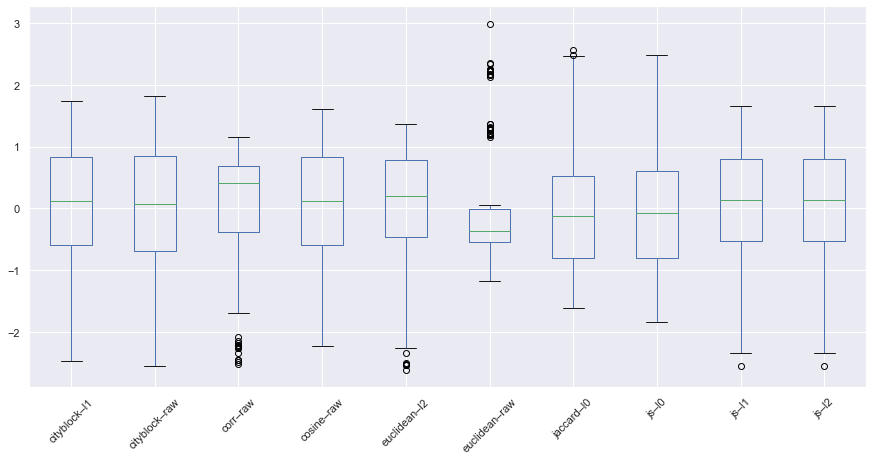

In [38]:
ZPAIRS.T.sort_index().T.plot.box(rot=45, figsize=(15,7));

In [39]:
# ZPAIRS.describe().T.sort_values('std').style.background_gradient(cmap='GnBu', high=.5)

In [40]:
# ZPAIRS.corr().style.background_gradient(cmap='GnBu', high=.5, axis=None)

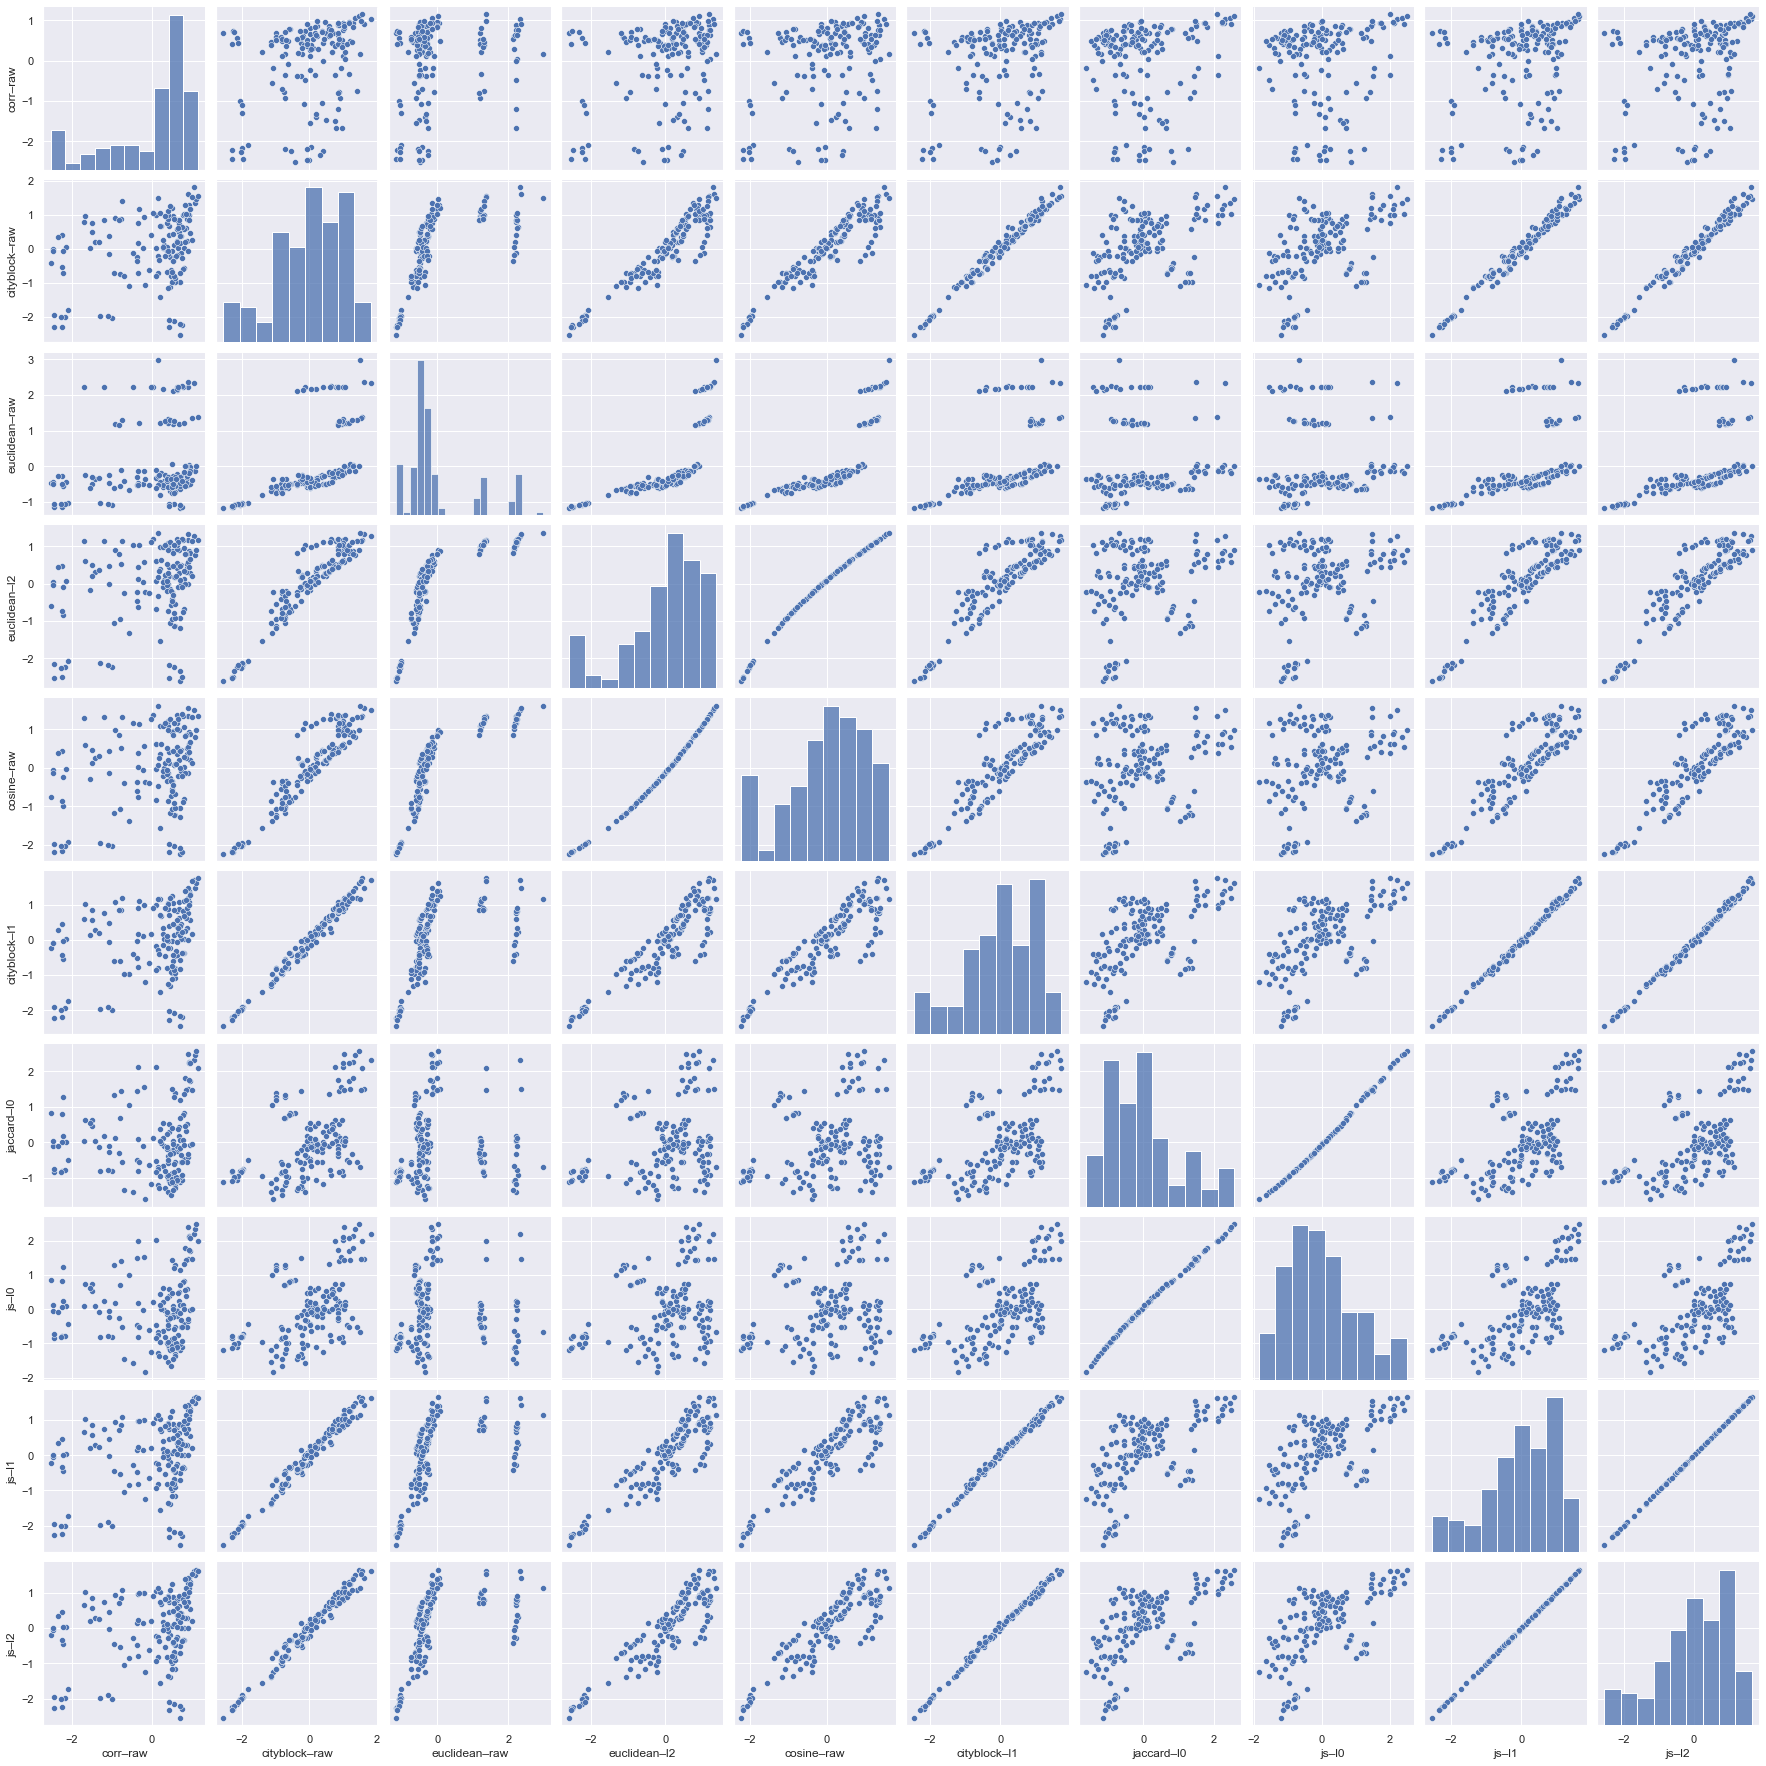

In [41]:
sns.pairplot(ZPAIRS);

# Create Clusters

## Hiearchical

In [42]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [43]:
def hca(sims, title="My Dendrogram", linkage_method='weighted', color_thresh=None, figsize=(7, 7)):

    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.label.values
    if not color_thresh:
        color_thresh = pd.DataFrame(tree)[2].median()
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(title, fontsize=20)

In [44]:
# sch.dendrogram?

<ipython-input-43-29d4b1fb3542>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

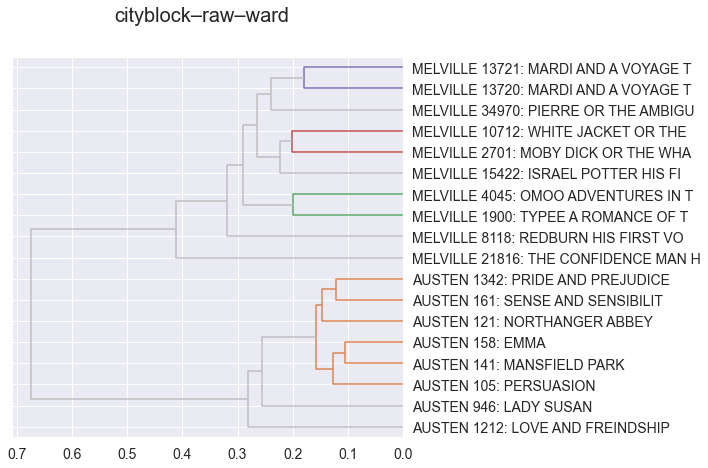

<Figure size 432x288 with 0 Axes>

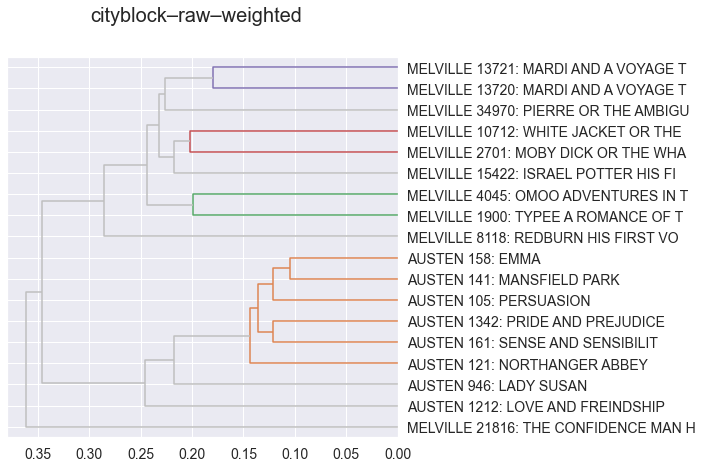

<Figure size 432x288 with 0 Axes>

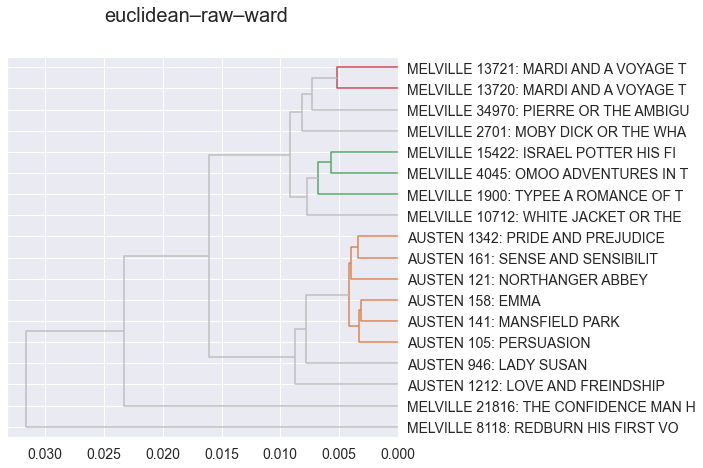

<Figure size 432x288 with 0 Axes>

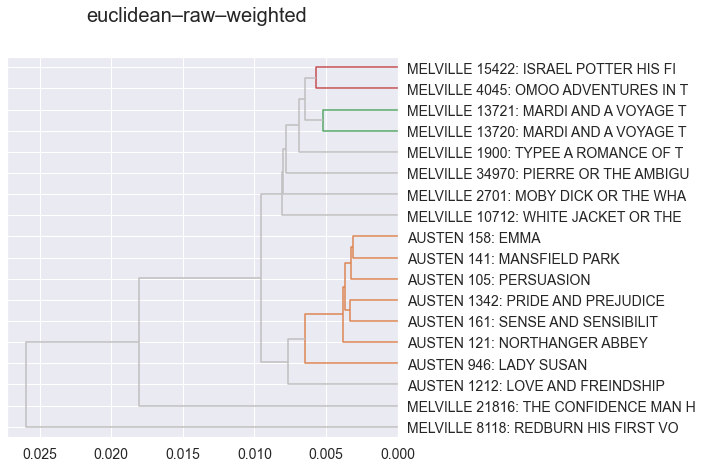

<Figure size 432x288 with 0 Axes>

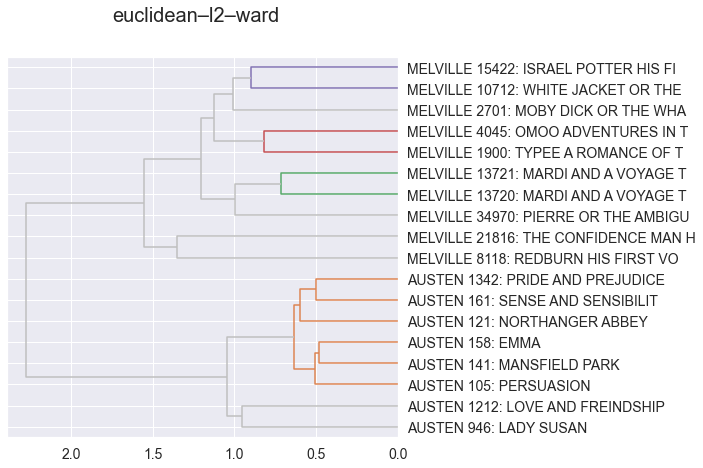

<Figure size 432x288 with 0 Axes>

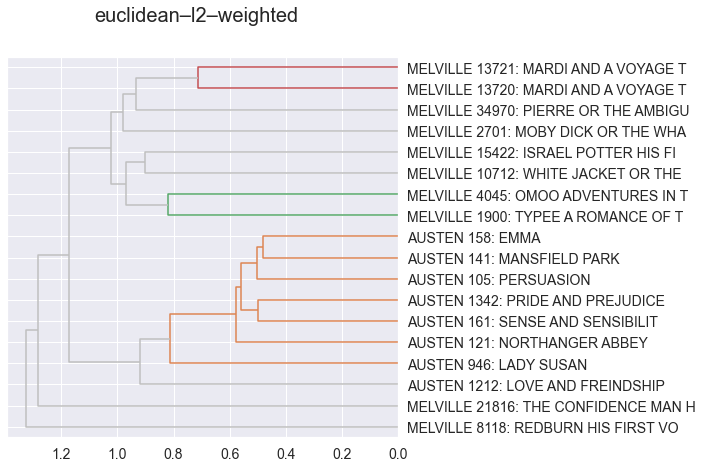

<Figure size 432x288 with 0 Axes>

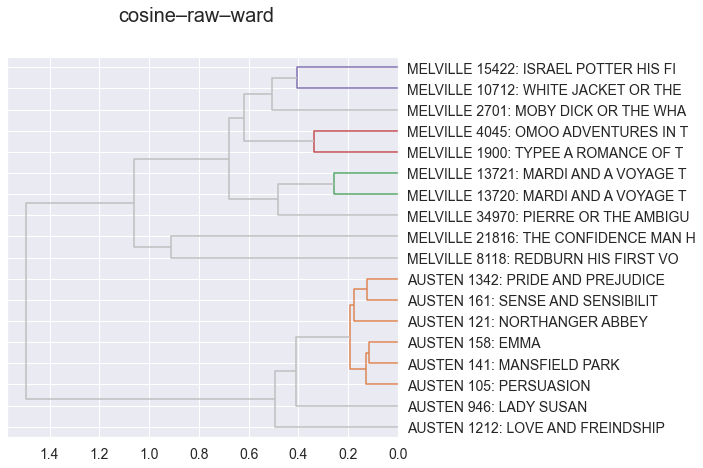

<Figure size 432x288 with 0 Axes>

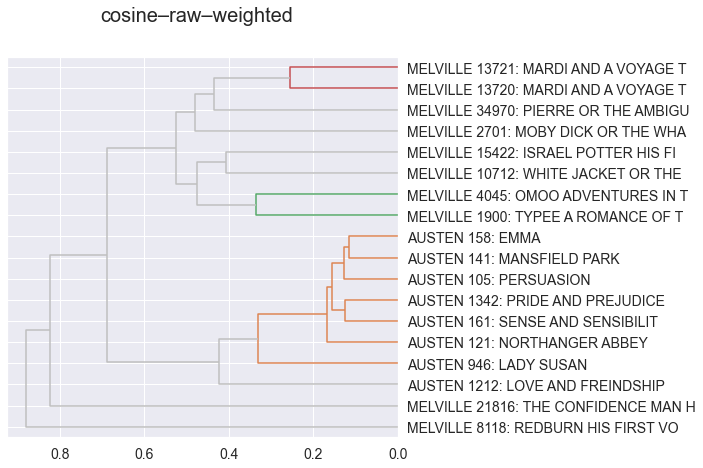

<Figure size 432x288 with 0 Axes>

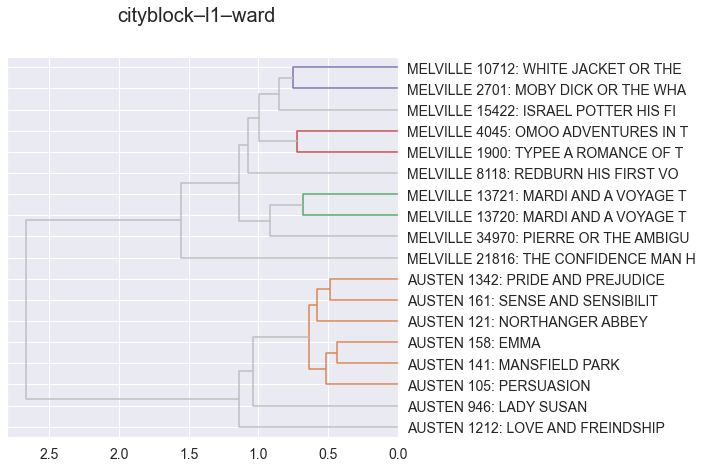

<Figure size 432x288 with 0 Axes>

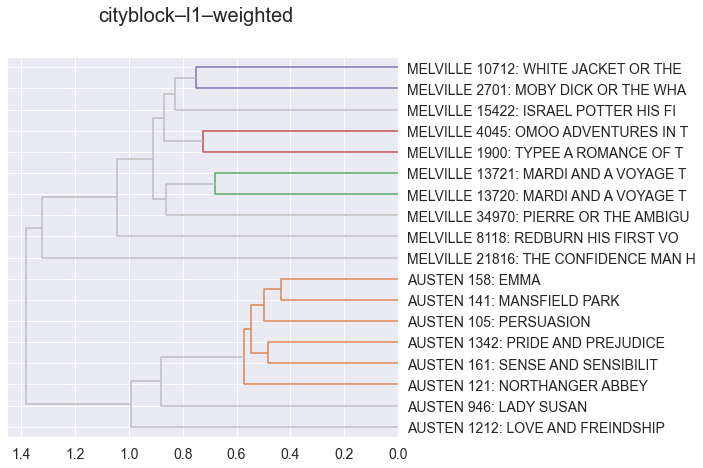

<Figure size 432x288 with 0 Axes>

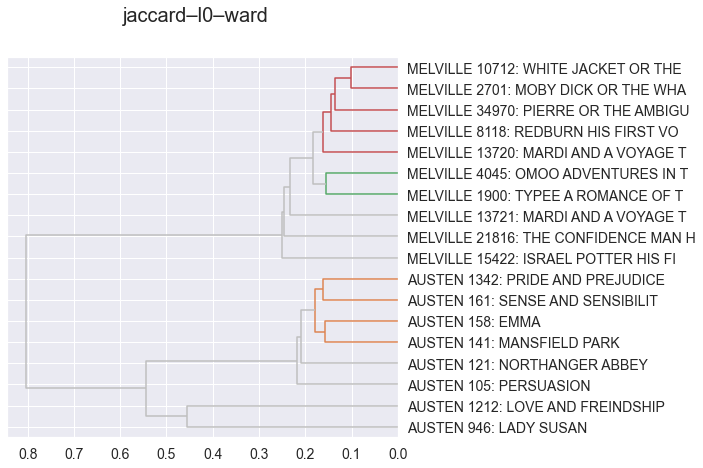

<Figure size 432x288 with 0 Axes>

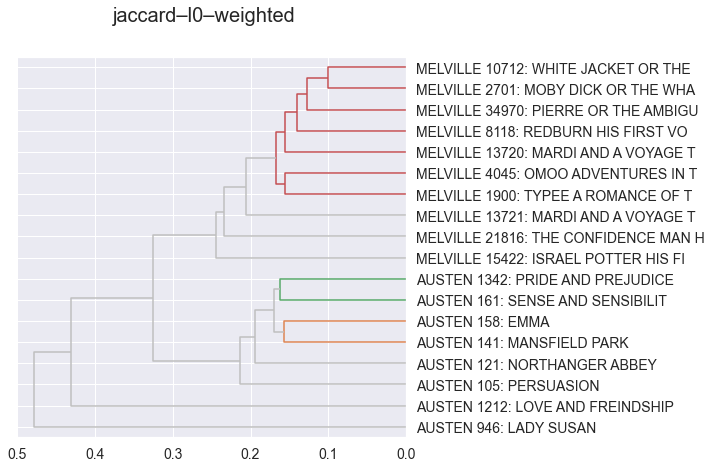

<Figure size 432x288 with 0 Axes>

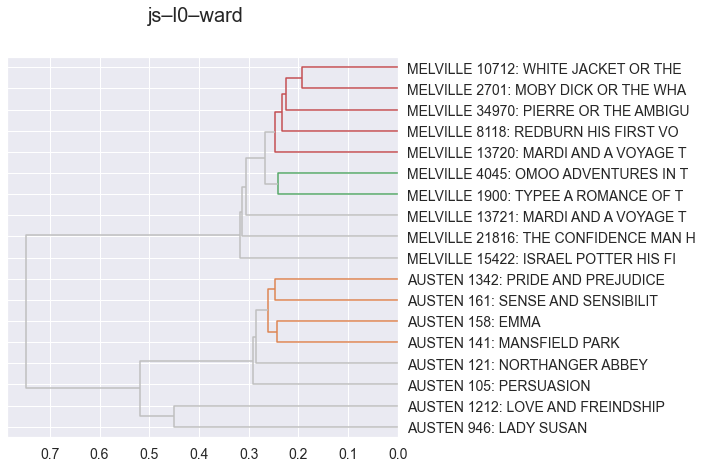

<Figure size 432x288 with 0 Axes>

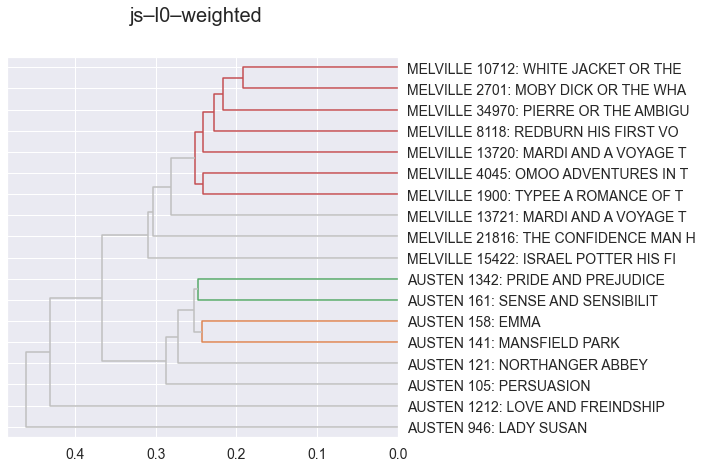

<Figure size 432x288 with 0 Axes>

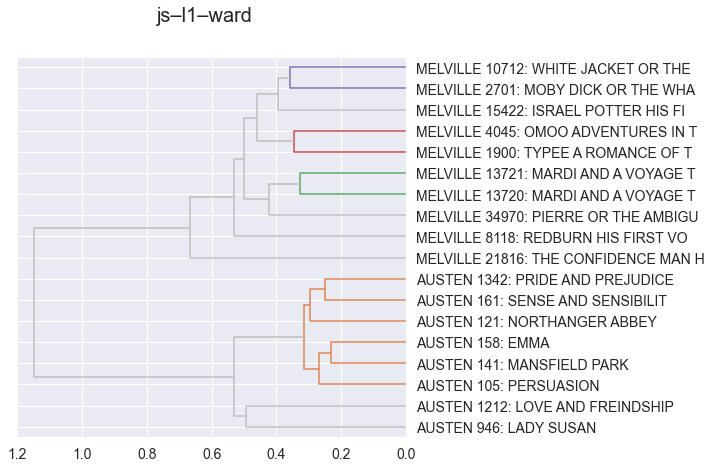

<Figure size 432x288 with 0 Axes>

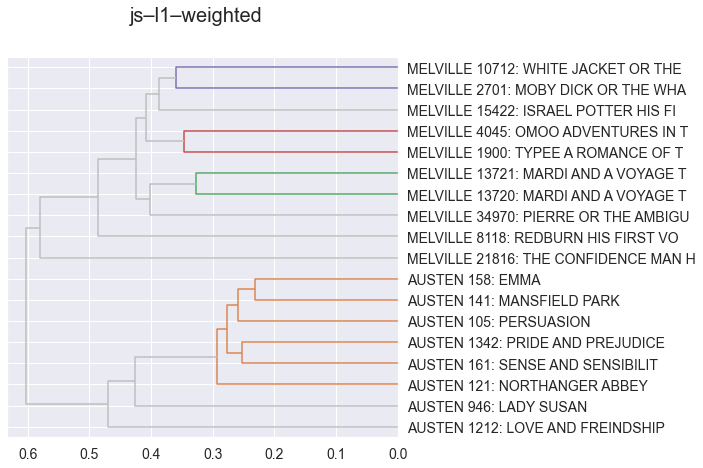

<Figure size 432x288 with 0 Axes>

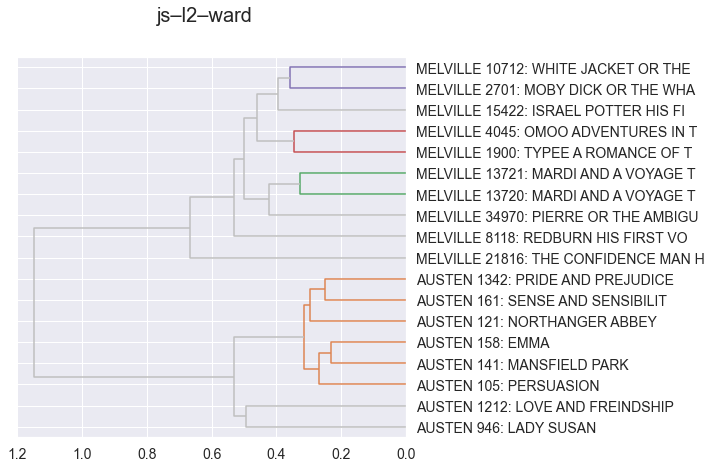

<Figure size 432x288 with 0 Axes>

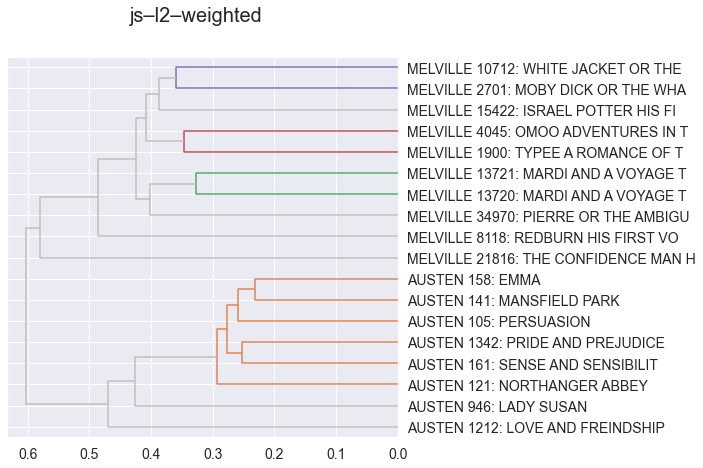

In [45]:
for combo in combos:
    m = combo[-1]
    for l in ['ward','weighted']:
        title = f"{m}–{l}"
        hca(PAIRS[m], title, linkage_method=l)

## Manual color thresholds 

In [46]:
PAIRS.columns.to_list()

['corr–raw',
 'cityblock–raw',
 'euclidean–raw',
 'euclidean–l2',
 'cosine–raw',
 'cityblock–l1',
 'jaccard–l0',
 'js–l0',
 'js–l1',
 'js–l2']

<Figure size 432x288 with 0 Axes>

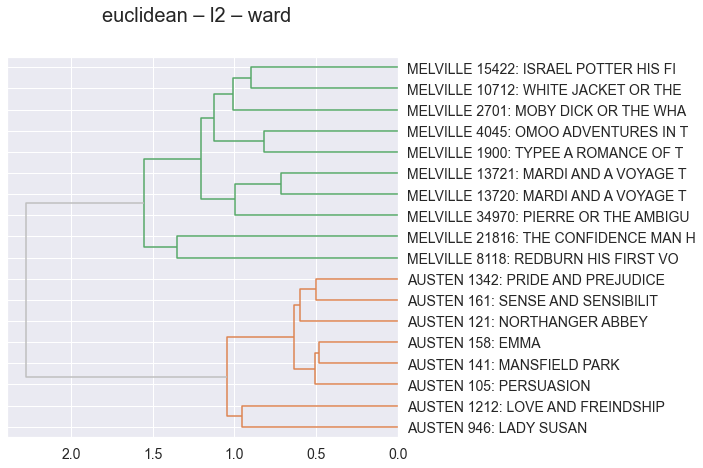

In [67]:
hca(PAIRS['euclidean–l2'], 'euclidean – l2 – ward', linkage_method='ward', color_thresh=1.6)

<Figure size 432x288 with 0 Axes>

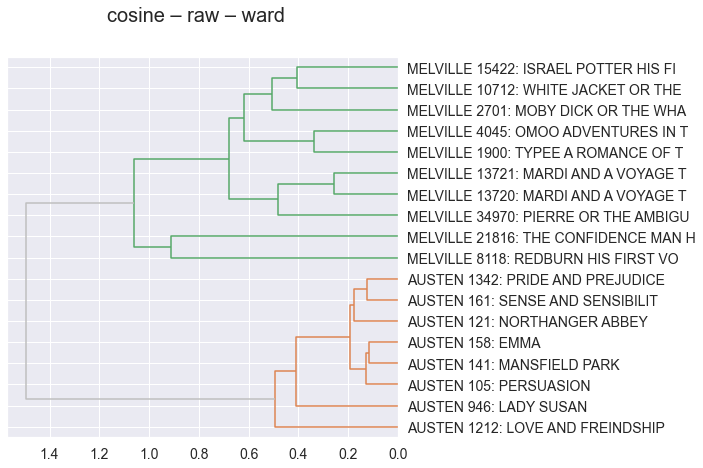

In [47]:
hca(PAIRS['cosine–raw'], 'cosine – raw – ward', linkage_method='ward', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

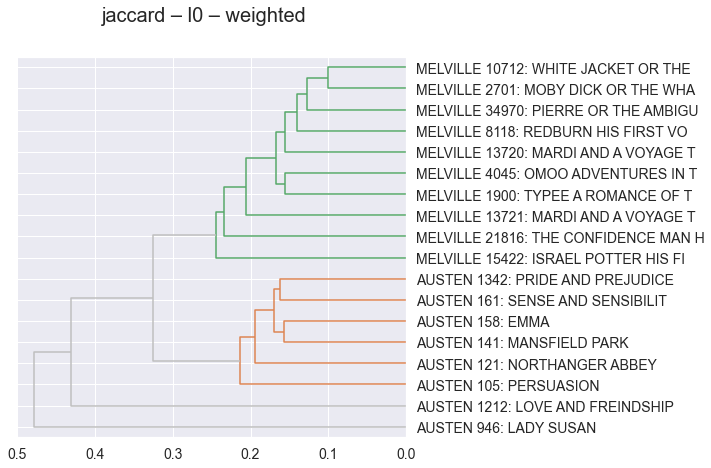

In [48]:
hca(PAIRS['jaccard–l0'], 'jaccard – l0 – weighted', linkage_method='weighted', color_thresh=.3);

<Figure size 432x288 with 0 Axes>

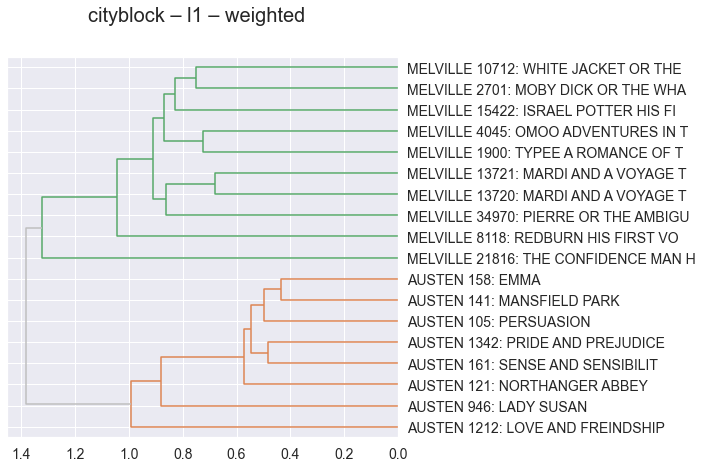

In [49]:
hca(PAIRS['cityblock–l1'], 'cityblock – l1 – weighted', linkage_method='weighted', color_thresh=1.35);

<Figure size 432x288 with 0 Axes>

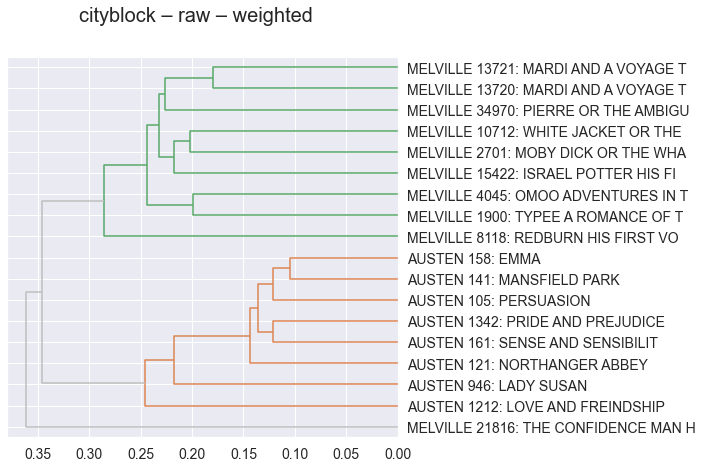

In [69]:
hca(PAIRS['cityblock–raw'], 'cityblock – raw – weighted', linkage_method='weighted', color_thresh=.34);

<Figure size 432x288 with 0 Axes>

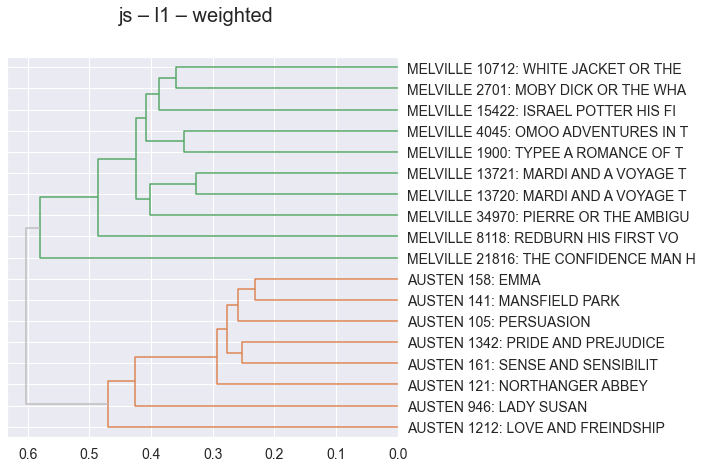

In [51]:
hca(PAIRS['js–l1'], 'js – l1 – weighted', linkage_method='weighted', color_thresh=.6);

<Figure size 432x288 with 0 Axes>

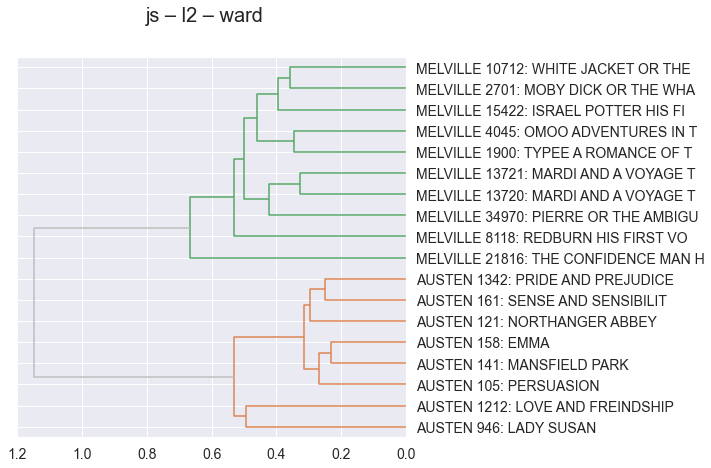

In [52]:
hca(PAIRS['js–l2'], 'js – l2 – ward', linkage_method='ward', color_thresh=.8);

In [53]:
plt.close() # Save memory

## K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [105]:
from sklearn.cluster import KMeans

In [146]:
n_clusters = 2
# n_clusters = 4
# n_clusters = 6

In [147]:
km = KMeans(n_clusters)
DOC['y_raw'] = km.fit_predict(TFIDF)
DOC['y_L0'] = km.fit_predict(L0)
DOC['y_L1'] = km.fit_predict(L1)
DOC['y_L2'] = km.fit_predict(L2)

In [148]:
DOC.iloc[:,1:].sort_values('label').style.background_gradient(cmap='YlGn')

In [131]:
y_col = 'y_L1'

In [132]:
DOC.sort_values(y_col)[['author','title',y_col]].style.background_gradient()

# Save Work

## Reduced BOW

Stack and pack the matrices.

In [61]:
BOW_REDUCED = TFIDF.stack().to_frame('tfidf')
BOW_REDUCED['binary'] = L0.stack()
BOW_REDUCED['tfidf_l1'] = L1.stack()
BOW_REDUCED['tfidf_l2'] = L2.stack()

In [62]:
BOW_REDUCED

tfidf  binary  tfidf_l1  tfidf_l2
book_id term_str                                         
105     had          0.000988       1  0.004027  0.153528
        is           0.000229       1  0.000932  0.035548
        have         0.000374       1  0.001522  0.058029
        were         0.000338       1  0.001378  0.052557
        very         0.000608       1  0.002477  0.094437
...                       ...     ...       ...       ...
34970   appearances  0.000016       1  0.000062  0.002150
        relish       0.000003       1  0.000013  0.000444
        elbow        0.000039       1  0.000148  0.005108
        avail        0.000013       1  0.000052  0.001786
        traced       0.000057       1  0.000220  0.007596

[67104 rows x 4 columns]

In [63]:
# BOW.n.unstack().corr()

## Save

In [64]:
BOW_REDUCED.to_csv(f"{data_home}/output/{data_prefix}-BOW_REDUCED.csv")